# 此份代码来源
https://www.kaggle.com/aralsarrafi/flowers-resnet50-tensorflow
# 待学习链接
https://blog.csdn.net/wf592523813/article/details/94478006?utm_medium=distribute.pc_relevant_t0.none-task-blog-BlogCommendFromMachineLearnPai2-1.channel_param&depth_1-utm_source=distribute.pc_relevant_t0.none-task-blog-BlogCommendFromMachineLearnPai2-1.channel_param

https://www.baidu.com/link?url=5VywaI7fOaH1nVJXM8oTTZ5fO_bTA2WtSrEMOdY_YrfcGDTpAQ3wSwNdIBnaIAnOeOiv9Y4EJo4xhASOcJCnra&wd=&eqid=a9c857cc000428a7000000065faf5585

https://www.cnblogs.com/hutao722/p/10008581.html 【从这里来看，依然是个尝试的过程？】

https://www.zhihu.com/question/273633408/answer/369134332 【关于ImageNet数据集】

https://www.cnblogs.com/BlueBlueSea/p/11067521.html 【对于dropout的别人的尝试】

https://blog.csdn.net/qq_27292549/article/details/81092653 【不确定值不值得看，大概率不值得】

In [1]:
import numpy as np
np.random.seed(42)
import tensorflow.compat.v1 as tf
import keras as K
import pandas as pd
import os

os.environ['CUDA_VISIBLE_DEVICES']='0'
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras import backend
# from numba import cuda
from keras.models import load_model
import time 
%matplotlib inline 

Using TensorFlow backend.


In [2]:
# import tensorflow as tf # tf.__version__ == 2.1.0, keras.__version__ == 2.3.1
# https://blog.csdn.net/u012388993/article/details/102573008
# import keras.backend.tensorflow_backend as ktf
# https://blog.csdn.net/zuoyouzouzou/article/details/104329286
import tensorflow.compat.v1 as tf
import tensorflow.compat.v1.keras.backend as ktf

# GPU 显存自动调用
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
session = tf.Session(config=config)
ktf.set_session(session)

In [3]:
train_path = r'flowers_google'
labels_path = "flowers_label.csv"
ids_path = "flowers_idx.csv"

In [4]:
def PrepareAnnotation(ids_path, labels_path, train_path):
    
    ids = pd.read_csv(ids_path)
    labels  = pd.read_csv(labels_path)
    
    annotation_dict = {}

    for i in range(len(ids['id'])):
        image_id = ids['id'][i]
        image_lable = ids['flower_cls'][i]
        annotation_dict[image_id] = image_lable
    
    label_dict = {}
    num_classes = 0

    for i in range(len(labels['flower_class'])):
        label_dict[labels['flower_class'][i]] = labels['label'][i]
        num_classes+=1
        
    for key, value in annotation_dict.items():
        annotation_dict[key] = label_dict[value]
    
    image_pathes = []
    targets = []
    
    for key, value in annotation_dict.items():
        
        image_name = str(key) + ".jpeg"
        image_path = os.path.join(train_path, image_name)
        image_pathes.append(image_path)
        targets.append(value)
    
    return image_pathes, targets, num_classes

In [5]:
image_pathes, targets, num_classes = PrepareAnnotation(ids_path, labels_path, train_path)

In [6]:
val_ratio = 0.2
x_train, x_val, y_train, y_val = train_test_split(image_pathes, targets, test_size=val_ratio, random_state=42, shuffle = True, stratify = targets)
print("num_train = ", len(x_train))
print("num_valid = ", len(x_val))

num_train =  13172
num_valid =  3293


In [7]:
def SelectSamplesForEachClass(x_train, y_train, num_examples):
    class_image_path = {}
    
    for i in range(len(y_train)):
        if (y_train[i] in class_image_path):
            if len(class_image_path[y_train[i]]) < num_examples:
                   class_image_path[y_train[i]].append(x_train[i])
        
        else:
            class_image_path[y_train[i]] = [x_train[i]]        
    
    return class_image_path

# 仅仅是展示数据集中的某些图像

In [8]:
class_label = 19 # Try other Classes.
num_examples_to_show = 30

class_image_path_ = SelectSamplesForEachClass(x_train, y_train, num_examples_to_show)

images = class_image_path_[class_label]

# fig, ax = plt.subplots(6,5, figsize=(15,12))
# fig.subplots_adjust(hspace = 0.4, wspace = 0.4)

# ax = ax.ravel()
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     ax[i].imshow(img)
    
#     plt.imshow(img)
    
    title_txt = image.split("/")[-1] + "   " + "Class = " + str(class_label)
#     ax[i].set_title(title_txt)
    i+=1

In [9]:
def Generator(X, Y, batch_size=16, mode='test'):
    iter_index=0
    while True:
        if mode=='test':
            index_end = min((iter_index+1)*batch_size,len(X))
            indexes = np.arange(iter_index*batch_size,index_end)
            if (iter_index+1)*batch_size >= len(X):  # 防止下一个epoch崩溃
                iter_index = 0

            iter_index+=1
        else:
            indexes = np.random.choice(len(X), batch_size)
        x = []
        y = []
    
        for index in indexes:
            x.append(X[index]) 
            y.append(Y[index])
        
        x_batch = []
        
        y_batch = K.utils.to_categorical(y, num_classes= num_classes)
        
        for i in range(len(x)):
            image = cv2.imread(x[i])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = K.applications.resnet50.preprocess_input(image)
            x_batch.append(image)
        
        x_batch = np.array(x_batch)
        
        yield x_batch, y_batch

In [10]:
def ResNet50Model():
    model = K.applications.ResNet50(include_top=False, weights=None, input_shape =(224, 224, 3))
    
    new_output = K.layers.GlobalAveragePooling2D()(model.output)
    new_output = K.layers.Dense(num_classes, activation = 'softmax')(new_output)
    
    model = K.engine.training.Model(model.inputs, new_output)
    
    return model

In [11]:
model = ResNet50Model()

C:\Users\Admin\anaconda3\envs\keras\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [12]:
# Freez first 168 Layers Except the Batch Normalization ones.
num_feerezed_layer = 168

for layer in model.layers:
    layer.trainable = True
    
    if isinstance(layer, K.layers.BatchNormalization):
        # Set Batch Norm momentun to 0.9 to faster adapt to the new DataSet.
        layer.momentum = 0.9

for layer in model.layers:#[:num_feerezed_layer]:
    
    if not isinstance(layer, (K.layers.Dense,K.layers.BatchNormalization)):
        layer.trainable = False
        
# Check if the trainable layers are set Correctly
for layer in model.layers:
    print(layer.name, " ", "trainable = ", layer.trainable)

input_1   trainable =  False
conv1_pad   trainable =  False
conv1   trainable =  False
bn_conv1   trainable =  True
activation_1   trainable =  False
pool1_pad   trainable =  False
max_pooling2d_1   trainable =  False
res2a_branch2a   trainable =  False
bn2a_branch2a   trainable =  True
activation_2   trainable =  False
res2a_branch2b   trainable =  False
bn2a_branch2b   trainable =  True
activation_3   trainable =  False
res2a_branch2c   trainable =  False
res2a_branch1   trainable =  False
bn2a_branch2c   trainable =  True
bn2a_branch1   trainable =  True
add_1   trainable =  False
activation_4   trainable =  False
res2b_branch2a   trainable =  False
bn2b_branch2a   trainable =  True
activation_5   trainable =  False
res2b_branch2b   trainable =  False
bn2b_branch2b   trainable =  True
activation_6   trainable =  False
res2b_branch2c   trainable =  False
bn2b_branch2c   trainable =  True
add_2   trainable =  False
activation_7   trainable =  False
res2c_branch2a   trainable =  False


In [13]:
model.summary()# 256*7+1*256+1024*1+256*1+1024*1+512*1+2048*2+512*2+2048*1+512*2+2048+512*2+2048+1024+4096*2+1024+4096+1024+4096+1024*2+496+1024*2+4096+1024+1024+4096+2048+2048+8192+8192+2048+2048+8192+2048+2048+8192

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [14]:
batch_size = 32 # Tesla 上占用9013MB
model_root = 'models/freeze-allconv-nopretrained-models_'+str(batch_size)
checkpoint = ModelCheckpoint(os.path.join(model_root,'Best_Model.h5'),
                             verbose=1, monitor='val_accuracy',save_best_only=True, mode='max')

In [15]:
model.compile(loss='categorical_crossentropy', optimizer = K.optimizers.Adamax(lr=0.01), metrics=['accuracy'])

In [16]:
from tqdm import tqdm 

if not os.path.exists(model_root):
    os.makedirs(model_root)
    
train_losses = [] 
train_accs = [] 
test_losses = []
test_accs = [] 
train_indices = [] 
test_indices = [] 
test_loss_temp_restore = [] 
test_acc_temp_restore = []
best_acc = 0
batch_num = np.ceil(len(x_train)/batch_size)
index = 0

time_begin = time.time()
for epoch in range(20):
    train_generator = Generator(x_train, y_train, batch_size)
    test_generator = Generator(x_val, y_val, 4*batch_size)
    bar = tqdm(total = batch_num, ncols=90)
    for batch, label in train_generator:
        bar.set_description_str(f'{epoch+1}/20epochs')

        index += 1
        train_loss, train_acc = model.train_on_batch(batch, label)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        train_indices.append(index)
        if (index-1)%30==0:
            test_loss=test_acc=0
            test_times = np.ceil(len(x_val)/4/batch_size)
#             bar_test = tqdm(total=test_times, ncols = 90)
            bar.set_description_str('val')
            test_loss_temp_ls = []
            test_acc_temp_ls = []
            for test_index in range(int(test_times)):
                batch, label = next(test_generator)
                test_loss_temp, test_acc_temp = model.test_on_batch(batch, label)
                test_loss_temp_ls.append(test_loss_temp)
                test_acc_temp_ls.append(test_acc_temp)
                test_loss+=test_loss_temp 
                test_acc+=test_acc_temp
                bar.set_postfix_str('loss:{:.2f}, acc:{:.2f}%'.format(test_loss_temp,test_acc_temp*100))
#                 bar_test.update(1)
                if test_index == test_times-1:
                    break
            test_loss_temp_restore.append(test_loss_temp_ls)
            test_acc_temp_restore.append(test_acc_temp_ls)
            test_loss = test_loss/test_times
            test_acc = test_acc/test_times
            test_losses.append(test_loss)
            test_accs.append(test_acc)
            test_indices.append(index)
            
            
            if test_acc > 0.8 and test_acc >= best_acc:
                model.save(os.path.join(model_root, 'flower_{}_{}_{:.4f}.h5'.format(epoch, index, test_acc)))
                model.save(os.path.join(model_root, 'Best_Model.h5'))
                best_acc = test_acc
        bar.set_postfix_str('loss:{:.2f}, acc:{:.2f}%'.format(train_loss,train_acc*100))
        bar.update(1)
        if index % batch_num == 0:
#             bar.moveto(0)
            break
time_end = time.time()
# model.fit(Generator(x_train, y_train, batch_size), 
#           steps_per_epoch=len(x_train)//batch_size,
#           epochs= 4,
#           validation_data=Generator(x_val, y_val, batch_size),
#           validation_steps=len(x_val) // batch_size,
#           callbacks=[checkpoint])

1/20epochs: 100%|██████████████| 412/412.0 [10:12<00:00,  1.33it/s, loss:3.72, acc:15.00%]
1/20epochs: 100%|██████████████| 412/412.0 [10:12<00:00,  1.49s/it, loss:3.72, acc:15.00%]

2/20epochs:   0%|                                               | 0/412.0 [00:00<?, ?it/s]
2/20epochs:   0%|                         | 0/412.0 [00:00<?, ?it/s, loss:4.18, acc:3.12%]
2/20epochs:   0%|                 | 1/412.0 [00:00<01:32,  4.43it/s, loss:4.18, acc:3.12%]
2/20epochs:   0%|                 | 1/412.0 [00:00<01:32,  4.43it/s, loss:4.18, acc:3.12%]
2/20epochs:   0%|                 | 1/412.0 [00:00<01:32,  4.43it/s, loss:4.53, acc:0.00%]
2/20epochs:   0%|                 | 2/412.0 [00:00<01:32,  4.43it/s, loss:4.53, acc:0.00%]
2/20epochs:   0%|                 | 2/412.0 [00:00<01:32,  4.43it/s, loss:4.53, acc:0.00%]
2/20epochs:   0%|                 | 2/412.0 [00:00<01:32,  4.43it/s, loss:4.73, acc:9.38%]
2/20epochs:   1%|                 | 3/412.0 [00:00<01:32,  4.43it/s, loss:4.73, acc:9.38%

2/20epochs:   9%|█▍             | 39/412.0 [00:29<20:33,  3.31s/it, loss:4.73, acc:12.50%]
2/20epochs:  10%|█▍             | 40/412.0 [00:29<14:46,  2.38s/it, loss:4.73, acc:12.50%]
2/20epochs:  10%|█▍             | 40/412.0 [00:29<14:46,  2.38s/it, loss:4.73, acc:12.50%]
2/20epochs:  10%|█▌              | 40/412.0 [00:29<14:46,  2.38s/it, loss:4.43, acc:6.25%]
2/20epochs:  10%|█▌              | 41/412.0 [00:29<10:44,  1.74s/it, loss:4.43, acc:6.25%]
2/20epochs:  10%|█▌              | 41/412.0 [00:29<10:44,  1.74s/it, loss:4.43, acc:6.25%]
2/20epochs:  10%|█▌              | 41/412.0 [00:30<10:44,  1.74s/it, loss:4.67, acc:3.12%]
2/20epochs:  10%|█▋              | 42/412.0 [00:30<07:54,  1.28s/it, loss:4.67, acc:3.12%]
2/20epochs:  10%|█▋              | 42/412.0 [00:30<07:54,  1.28s/it, loss:4.67, acc:3.12%]
2/20epochs:  10%|█▋              | 42/412.0 [00:30<07:54,  1.28s/it, loss:4.16, acc:9.38%]
2/20epochs:  10%|█▋              | 43/412.0 [00:30<05:56,  1.04it/s, loss:4.16, acc:9.38%]

2/20epochs:  21%|███▏           | 88/412.0 [00:50<01:14,  4.35it/s, loss:4.58, acc:15.62%]
2/20epochs:  22%|███▏           | 89/412.0 [00:50<01:13,  4.37it/s, loss:4.58, acc:15.62%]
2/20epochs:  22%|███▏           | 89/412.0 [00:51<01:13,  4.37it/s, loss:4.58, acc:15.62%]
2/20epochs:  22%|███▏           | 89/412.0 [00:51<01:13,  4.37it/s, loss:4.08, acc:18.75%]
2/20epochs:  22%|███▎           | 90/412.0 [00:51<01:13,  4.37it/s, loss:4.08, acc:18.75%]
2/20epochs:  22%|███▎           | 90/412.0 [00:51<01:13,  4.37it/s, loss:4.08, acc:18.75%]
2/20epochs:  22%|███▍            | 90/412.0 [00:51<01:13,  4.37it/s, loss:4.74, acc:3.12%]
2/20epochs:  22%|███▌            | 91/412.0 [00:51<01:13,  4.38it/s, loss:4.74, acc:3.12%]
2/20epochs:  22%|███▌            | 91/412.0 [00:51<01:13,  4.38it/s, loss:4.74, acc:3.12%]
2/20epochs:  22%|███▌            | 91/412.0 [00:51<01:13,  4.38it/s, loss:4.45, acc:0.00%]
2/20epochs:  22%|███▌            | 92/412.0 [00:51<01:12,  4.39it/s, loss:4.45, acc:0.00%]

val:  31%|██████▊               | 128/412.0 [01:20<01:04,  4.41it/s, loss:4.07, acc:6.25%]
val:  31%|██████▉               | 129/412.0 [01:20<15:34,  3.30s/it, loss:4.07, acc:6.25%]
2/20epochs:  31%|████▋          | 129/412.0 [01:20<15:34,  3.30s/it, loss:4.07, acc:6.25%]
2/20epochs:  31%|████▋          | 129/412.0 [01:20<15:34,  3.30s/it, loss:4.42, acc:6.25%]
2/20epochs:  32%|████▋          | 130/412.0 [01:20<11:11,  2.38s/it, loss:4.42, acc:6.25%]
2/20epochs:  32%|████▋          | 130/412.0 [01:20<11:11,  2.38s/it, loss:4.42, acc:6.25%]
2/20epochs:  32%|████▋          | 130/412.0 [01:21<11:11,  2.38s/it, loss:4.11, acc:6.25%]
2/20epochs:  32%|████▊          | 131/412.0 [01:21<08:07,  1.73s/it, loss:4.11, acc:6.25%]
2/20epochs:  32%|████▊          | 131/412.0 [01:21<08:07,  1.73s/it, loss:4.11, acc:6.25%]
2/20epochs:  32%|████▊          | 131/412.0 [01:21<08:07,  1.73s/it, loss:4.27, acc:9.38%]
2/20epochs:  32%|████▊          | 132/412.0 [01:21<05:58,  1.28s/it, loss:4.27, acc:9.38%]

2/20epochs:  43%|██████▍        | 177/412.0 [01:41<00:54,  4.32it/s, loss:4.27, acc:6.25%]
2/20epochs:  43%|██████▍        | 178/412.0 [01:41<00:53,  4.34it/s, loss:4.27, acc:6.25%]
2/20epochs:  43%|██████▍        | 178/412.0 [01:41<00:53,  4.34it/s, loss:4.27, acc:6.25%]
2/20epochs:  43%|██████▍        | 178/412.0 [01:42<00:53,  4.34it/s, loss:4.67, acc:3.12%]
2/20epochs:  43%|██████▌        | 179/412.0 [01:42<00:53,  4.36it/s, loss:4.67, acc:3.12%]
2/20epochs:  43%|██████▌        | 179/412.0 [01:42<00:53,  4.36it/s, loss:4.67, acc:3.12%]
2/20epochs:  43%|██████▌        | 179/412.0 [01:42<00:53,  4.36it/s, loss:4.64, acc:0.00%]
2/20epochs:  44%|██████▌        | 180/412.0 [01:42<00:53,  4.37it/s, loss:4.64, acc:0.00%]
2/20epochs:  44%|██████▌        | 180/412.0 [01:42<00:53,  4.37it/s, loss:4.64, acc:0.00%]
2/20epochs:  44%|██████▌        | 180/412.0 [01:42<00:53,  4.37it/s, loss:4.38, acc:6.25%]
2/20epochs:  44%|██████▌        | 181/412.0 [01:42<00:52,  4.38it/s, loss:4.38, acc:6.25%]

val:  53%|███████████▋          | 218/412.0 [02:10<00:43,  4.41it/s, loss:4.90, acc:9.38%]
val:  53%|███████████▋          | 218/412.0 [02:11<00:43,  4.41it/s, loss:5.10, acc:7.03%]
val:  53%|███████████▋          | 218/412.0 [02:11<00:43,  4.41it/s, loss:4.95, acc:5.47%]
val:  53%|███████████▋          | 218/412.0 [02:11<00:43,  4.41it/s, loss:4.29, acc:0.00%]
val:  53%|███████████▋          | 219/412.0 [02:11<10:35,  3.29s/it, loss:4.29, acc:0.00%]
2/20epochs:  53%|███████▉       | 219/412.0 [02:11<10:35,  3.29s/it, loss:4.29, acc:0.00%]
2/20epochs:  53%|███████▉       | 219/412.0 [02:11<10:35,  3.29s/it, loss:5.23, acc:0.00%]
2/20epochs:  53%|████████       | 220/412.0 [02:11<07:35,  2.37s/it, loss:5.23, acc:0.00%]
2/20epochs:  53%|████████       | 220/412.0 [02:11<07:35,  2.37s/it, loss:5.23, acc:0.00%]
2/20epochs:  53%|████████       | 220/412.0 [02:12<07:35,  2.37s/it, loss:4.83, acc:0.00%]
2/20epochs:  54%|████████       | 221/412.0 [02:12<05:30,  1.73s/it, loss:4.83, acc:0.00%]

2/20epochs:  65%|█████████▋     | 266/412.0 [02:32<00:34,  4.28it/s, loss:4.89, acc:6.25%]
2/20epochs:  65%|█████████▋     | 267/412.0 [02:32<00:33,  4.32it/s, loss:4.89, acc:6.25%]
2/20epochs:  65%|█████████▋     | 267/412.0 [02:32<00:33,  4.32it/s, loss:4.89, acc:6.25%]
2/20epochs:  65%|█████████▋     | 267/412.0 [02:33<00:33,  4.32it/s, loss:4.29, acc:3.12%]
2/20epochs:  65%|█████████▊     | 268/412.0 [02:33<00:33,  4.36it/s, loss:4.29, acc:3.12%]
2/20epochs:  65%|█████████▊     | 268/412.0 [02:33<00:33,  4.36it/s, loss:4.29, acc:3.12%]
2/20epochs:  65%|█████████▊     | 268/412.0 [02:33<00:33,  4.36it/s, loss:4.32, acc:9.38%]
2/20epochs:  65%|█████████▊     | 269/412.0 [02:33<00:32,  4.38it/s, loss:4.32, acc:9.38%]
2/20epochs:  65%|█████████▊     | 269/412.0 [02:33<00:32,  4.38it/s, loss:4.32, acc:9.38%]
2/20epochs:  65%|█████████▊     | 269/412.0 [02:33<00:32,  4.38it/s, loss:4.47, acc:3.12%]
2/20epochs:  66%|█████████▊     | 270/412.0 [02:33<00:32,  4.39it/s, loss:4.47, acc:3.12%]

val:  75%|████████████████▍     | 308/412.0 [03:00<00:23,  4.40it/s, loss:4.73, acc:4.69%]
val:  75%|████████████████▍     | 308/412.0 [03:01<00:23,  4.40it/s, loss:4.60, acc:8.59%]
val:  75%|███████████████▋     | 308/412.0 [03:01<00:23,  4.40it/s, loss:4.49, acc:13.28%]
val:  75%|████████████████▍     | 308/412.0 [03:02<00:23,  4.40it/s, loss:4.47, acc:7.81%]
val:  75%|████████████████▍     | 308/412.0 [03:02<00:23,  4.40it/s, loss:4.99, acc:6.25%]
val:  75%|████████████████▍     | 308/412.0 [03:02<00:23,  4.40it/s, loss:5.01, acc:7.81%]
val:  75%|████████████████▍     | 308/412.0 [03:02<00:23,  4.40it/s, loss:4.30, acc:3.12%]
val:  75%|████████████████▌     | 309/412.0 [03:02<05:39,  3.30s/it, loss:4.30, acc:3.12%]
2/20epochs:  75%|███████████▎   | 309/412.0 [03:02<05:39,  3.30s/it, loss:4.30, acc:3.12%]
2/20epochs:  75%|███████████▎   | 309/412.0 [03:03<05:39,  3.30s/it, loss:4.08, acc:3.12%]
2/20epochs:  75%|███████████▎   | 310/412.0 [03:03<04:02,  2.38s/it, loss:4.08, acc:3.12%]

2/20epochs:  86%|████████████▉  | 355/412.0 [03:23<00:13,  4.23it/s, loss:4.45, acc:6.25%]
2/20epochs:  86%|████████████▉  | 356/412.0 [03:23<00:13,  4.29it/s, loss:4.45, acc:6.25%]
2/20epochs:  86%|████████████▉  | 356/412.0 [03:23<00:13,  4.29it/s, loss:4.45, acc:6.25%]
2/20epochs:  86%|████████████▉  | 356/412.0 [03:23<00:13,  4.29it/s, loss:4.13, acc:9.38%]
2/20epochs:  87%|████████████▉  | 357/412.0 [03:23<00:12,  4.33it/s, loss:4.13, acc:9.38%]
2/20epochs:  87%|████████████▉  | 357/412.0 [03:24<00:12,  4.33it/s, loss:4.13, acc:9.38%]
2/20epochs:  87%|████████████▉  | 357/412.0 [03:24<00:12,  4.33it/s, loss:4.28, acc:6.25%]
2/20epochs:  87%|█████████████  | 358/412.0 [03:24<00:12,  4.35it/s, loss:4.28, acc:6.25%]
2/20epochs:  87%|█████████████  | 358/412.0 [03:24<00:12,  4.35it/s, loss:4.28, acc:6.25%]
2/20epochs:  87%|█████████████  | 358/412.0 [03:24<00:12,  4.35it/s, loss:4.50, acc:9.38%]
2/20epochs:  87%|█████████████  | 359/412.0 [03:24<00:12,  4.37it/s, loss:4.50, acc:9.38%]

val:  97%|█████████████████████▎| 398/412.0 [03:50<00:03,  4.41it/s, loss:4.94, acc:6.25%]
val:  97%|█████████████████████▎| 398/412.0 [03:51<00:03,  4.41it/s, loss:4.84, acc:8.59%]
val:  97%|████████████████████▎| 398/412.0 [03:51<00:03,  4.41it/s, loss:4.80, acc:10.94%]
val:  97%|█████████████████████▎| 398/412.0 [03:51<00:03,  4.41it/s, loss:4.20, acc:7.81%]
val:  97%|█████████████████████▎| 398/412.0 [03:52<00:03,  4.41it/s, loss:4.58, acc:4.69%]
val:  97%|█████████████████████▎| 398/412.0 [03:52<00:03,  4.41it/s, loss:4.79, acc:8.59%]
val:  97%|█████████████████████▎| 398/412.0 [03:53<00:03,  4.41it/s, loss:4.60, acc:3.91%]
val:  97%|█████████████████████▎| 398/412.0 [03:53<00:03,  4.41it/s, loss:4.44, acc:8.59%]
val:  97%|█████████████████████▎| 398/412.0 [03:53<00:03,  4.41it/s, loss:4.78, acc:3.12%]
val:  97%|█████████████████████▎| 398/412.0 [03:53<00:03,  4.41it/s, loss:4.33, acc:3.12%]
val:  97%|█████████████████████▎| 399/412.0 [03:53<00:42,  3.30s/it, loss:4.33, acc:3.12%]

4/20epochs:   8%|█▏              | 32/412.0 [00:17<03:02,  2.08it/s, loss:3.93, acc:9.38%]
4/20epochs:   8%|█▏              | 32/412.0 [00:17<03:02,  2.08it/s, loss:3.93, acc:9.38%]
4/20epochs:   8%|█▏              | 32/412.0 [00:17<03:02,  2.08it/s, loss:4.10, acc:9.38%]
4/20epochs:   8%|█▎              | 33/412.0 [00:17<02:33,  2.47it/s, loss:4.10, acc:9.38%]
4/20epochs:   8%|█▎              | 33/412.0 [00:17<02:33,  2.47it/s, loss:4.10, acc:9.38%]
4/20epochs:   8%|█▎              | 33/412.0 [00:17<02:33,  2.47it/s, loss:4.39, acc:3.12%]
4/20epochs:   8%|█▎              | 34/412.0 [00:17<02:12,  2.85it/s, loss:4.39, acc:3.12%]
4/20epochs:   8%|█▎              | 34/412.0 [00:18<02:12,  2.85it/s, loss:4.39, acc:3.12%]
4/20epochs:   8%|█▏             | 34/412.0 [00:18<02:12,  2.85it/s, loss:3.93, acc:15.62%]
4/20epochs:   8%|█▎             | 35/412.0 [00:18<01:58,  3.19it/s, loss:3.93, acc:15.62%]
4/20epochs:   8%|█▎             | 35/412.0 [00:18<01:58,  3.19it/s, loss:3.93, acc:15.62%]

4/20epochs:  20%|███▏            | 81/412.0 [00:38<01:14,  4.42it/s, loss:3.90, acc:3.12%]
4/20epochs:  20%|███▏            | 81/412.0 [00:38<01:14,  4.42it/s, loss:3.90, acc:3.12%]
4/20epochs:  20%|██▉            | 81/412.0 [00:39<01:14,  4.42it/s, loss:3.32, acc:12.50%]
4/20epochs:  20%|██▉            | 82/412.0 [00:39<01:14,  4.42it/s, loss:3.32, acc:12.50%]
4/20epochs:  20%|██▉            | 82/412.0 [00:39<01:14,  4.42it/s, loss:3.32, acc:12.50%]
4/20epochs:  20%|███▏            | 82/412.0 [00:39<01:14,  4.42it/s, loss:3.48, acc:9.38%]
4/20epochs:  20%|███▏            | 83/412.0 [00:39<01:14,  4.42it/s, loss:3.48, acc:9.38%]
4/20epochs:  20%|███▏            | 83/412.0 [00:39<01:14,  4.42it/s, loss:3.48, acc:9.38%]
4/20epochs:  20%|███            | 83/412.0 [00:39<01:14,  4.42it/s, loss:3.18, acc:25.00%]
4/20epochs:  20%|███            | 84/412.0 [00:39<01:14,  4.43it/s, loss:3.18, acc:25.00%]
4/20epochs:  20%|███            | 84/412.0 [00:39<01:14,  4.43it/s, loss:3.18, acc:25.00%]

4/20epochs:  29%|████          | 121/412.0 [01:08<02:51,  1.70it/s, loss:4.13, acc:12.50%]
4/20epochs:  29%|████          | 121/412.0 [01:08<02:51,  1.70it/s, loss:4.13, acc:12.50%]
4/20epochs:  29%|████▍          | 121/412.0 [01:08<02:51,  1.70it/s, loss:3.39, acc:9.38%]
4/20epochs:  30%|████▍          | 122/412.0 [01:08<02:19,  2.09it/s, loss:3.39, acc:9.38%]
4/20epochs:  30%|████▍          | 122/412.0 [01:08<02:19,  2.09it/s, loss:3.39, acc:9.38%]
4/20epochs:  30%|████▏         | 122/412.0 [01:08<02:19,  2.09it/s, loss:3.77, acc:15.62%]
4/20epochs:  30%|████▏         | 123/412.0 [01:08<01:56,  2.48it/s, loss:3.77, acc:15.62%]
4/20epochs:  30%|████▏         | 123/412.0 [01:08<01:56,  2.48it/s, loss:3.77, acc:15.62%]
4/20epochs:  30%|████▍          | 123/412.0 [01:09<01:56,  2.48it/s, loss:4.22, acc:6.25%]
4/20epochs:  30%|████▌          | 124/412.0 [01:09<01:40,  2.86it/s, loss:4.22, acc:6.25%]
4/20epochs:  30%|████▌          | 124/412.0 [01:09<01:40,  2.86it/s, loss:4.22, acc:6.25%]

4/20epochs:  41%|█████▊        | 170/412.0 [01:29<00:54,  4.42it/s, loss:4.46, acc:18.75%]
4/20epochs:  41%|█████▊        | 170/412.0 [01:29<00:54,  4.42it/s, loss:4.46, acc:18.75%]
4/20epochs:  41%|█████▊        | 170/412.0 [01:29<00:54,  4.42it/s, loss:3.69, acc:15.62%]
4/20epochs:  42%|█████▊        | 171/412.0 [01:29<00:54,  4.41it/s, loss:3.69, acc:15.62%]
4/20epochs:  42%|█████▊        | 171/412.0 [01:29<00:54,  4.41it/s, loss:3.69, acc:15.62%]
4/20epochs:  42%|██████▏        | 171/412.0 [01:30<00:54,  4.41it/s, loss:4.03, acc:6.25%]
4/20epochs:  42%|██████▎        | 172/412.0 [01:30<00:54,  4.41it/s, loss:4.03, acc:6.25%]
4/20epochs:  42%|██████▎        | 172/412.0 [01:30<00:54,  4.41it/s, loss:4.03, acc:6.25%]
4/20epochs:  42%|█████▊        | 172/412.0 [01:30<00:54,  4.41it/s, loss:3.85, acc:15.62%]
4/20epochs:  42%|█████▉        | 173/412.0 [01:30<00:54,  4.42it/s, loss:3.85, acc:15.62%]
4/20epochs:  42%|█████▉        | 173/412.0 [01:30<00:54,  4.42it/s, loss:3.85, acc:15.62%]

4/20epochs:  51%|███████▏      | 210/412.0 [01:59<02:29,  1.35it/s, loss:3.48, acc:21.88%]
4/20epochs:  51%|███████▏      | 210/412.0 [01:59<02:29,  1.35it/s, loss:3.48, acc:21.88%]
4/20epochs:  51%|███████▏      | 210/412.0 [01:59<02:29,  1.35it/s, loss:3.65, acc:12.50%]
4/20epochs:  51%|███████▏      | 211/412.0 [01:59<01:57,  1.70it/s, loss:3.65, acc:12.50%]
4/20epochs:  51%|███████▏      | 211/412.0 [01:59<01:57,  1.70it/s, loss:3.65, acc:12.50%]
4/20epochs:  51%|███████▋       | 211/412.0 [01:59<01:57,  1.70it/s, loss:3.83, acc:9.38%]
4/20epochs:  51%|███████▋       | 212/412.0 [01:59<01:35,  2.09it/s, loss:3.83, acc:9.38%]
4/20epochs:  51%|███████▋       | 212/412.0 [01:59<01:35,  2.09it/s, loss:3.83, acc:9.38%]
4/20epochs:  51%|███████▏      | 212/412.0 [01:59<01:35,  2.09it/s, loss:3.58, acc:21.88%]
4/20epochs:  52%|███████▏      | 213/412.0 [01:59<01:20,  2.48it/s, loss:3.58, acc:21.88%]
4/20epochs:  52%|███████▏      | 213/412.0 [01:59<01:20,  2.48it/s, loss:3.58, acc:21.88%]

4/20epochs:  63%|████████▊     | 259/412.0 [02:20<00:34,  4.42it/s, loss:3.79, acc:18.75%]
4/20epochs:  63%|████████▊     | 259/412.0 [02:20<00:34,  4.42it/s, loss:3.79, acc:18.75%]
4/20epochs:  63%|████████▊     | 259/412.0 [02:20<00:34,  4.42it/s, loss:3.56, acc:15.62%]
4/20epochs:  63%|████████▊     | 260/412.0 [02:20<00:34,  4.42it/s, loss:3.56, acc:15.62%]
4/20epochs:  63%|████████▊     | 260/412.0 [02:20<00:34,  4.42it/s, loss:3.56, acc:15.62%]
4/20epochs:  63%|████████▊     | 260/412.0 [02:20<00:34,  4.42it/s, loss:3.54, acc:12.50%]
4/20epochs:  63%|████████▊     | 261/412.0 [02:20<00:34,  4.42it/s, loss:3.54, acc:12.50%]
4/20epochs:  63%|████████▊     | 261/412.0 [02:21<00:34,  4.42it/s, loss:3.54, acc:12.50%]
4/20epochs:  63%|████████▊     | 261/412.0 [02:21<00:34,  4.42it/s, loss:2.93, acc:28.12%]
4/20epochs:  64%|████████▉     | 262/412.0 [02:21<00:33,  4.42it/s, loss:2.93, acc:28.12%]
4/20epochs:  64%|████████▉     | 262/412.0 [02:21<00:33,  4.42it/s, loss:2.93, acc:28.12%]

4/20epochs:  73%|██████████▏   | 299/412.0 [02:49<01:48,  1.04it/s, loss:3.61, acc:12.50%]
4/20epochs:  73%|██████████▏   | 299/412.0 [02:50<01:48,  1.04it/s, loss:3.61, acc:12.50%]
4/20epochs:  73%|██████████▏   | 299/412.0 [02:50<01:48,  1.04it/s, loss:3.33, acc:25.00%]
4/20epochs:  73%|██████████▏   | 300/412.0 [02:50<01:23,  1.35it/s, loss:3.33, acc:25.00%]
4/20epochs:  73%|██████████▏   | 300/412.0 [02:50<01:23,  1.35it/s, loss:3.33, acc:25.00%]
4/20epochs:  73%|██████████▏   | 300/412.0 [02:50<01:23,  1.35it/s, loss:3.53, acc:21.88%]
4/20epochs:  73%|██████████▏   | 301/412.0 [02:50<01:05,  1.70it/s, loss:3.53, acc:21.88%]
4/20epochs:  73%|██████████▏   | 301/412.0 [02:50<01:05,  1.70it/s, loss:3.53, acc:21.88%]
4/20epochs:  73%|██████████▉    | 301/412.0 [02:50<01:05,  1.70it/s, loss:3.77, acc:6.25%]
4/20epochs:  73%|██████████▉    | 302/412.0 [02:50<00:52,  2.09it/s, loss:3.77, acc:6.25%]
4/20epochs:  73%|██████████▉    | 302/412.0 [02:50<00:52,  2.09it/s, loss:3.77, acc:6.25%]

4/20epochs:  84%|███████████▊  | 348/412.0 [03:11<00:14,  4.39it/s, loss:3.77, acc:15.62%]
4/20epochs:  84%|███████████▊  | 348/412.0 [03:11<00:14,  4.39it/s, loss:3.77, acc:15.62%]
4/20epochs:  84%|████████████▋  | 348/412.0 [03:11<00:14,  4.39it/s, loss:3.16, acc:3.12%]
4/20epochs:  85%|████████████▋  | 349/412.0 [03:11<00:14,  4.40it/s, loss:3.16, acc:3.12%]
4/20epochs:  85%|████████████▋  | 349/412.0 [03:11<00:14,  4.40it/s, loss:3.16, acc:3.12%]
4/20epochs:  85%|████████████▋  | 349/412.0 [03:11<00:14,  4.40it/s, loss:4.22, acc:3.12%]
4/20epochs:  85%|████████████▋  | 350/412.0 [03:11<00:14,  4.41it/s, loss:4.22, acc:3.12%]
4/20epochs:  85%|████████████▋  | 350/412.0 [03:11<00:14,  4.41it/s, loss:4.22, acc:3.12%]
4/20epochs:  85%|███████████▉  | 350/412.0 [03:11<00:14,  4.41it/s, loss:3.97, acc:12.50%]
4/20epochs:  85%|███████████▉  | 351/412.0 [03:11<00:13,  4.41it/s, loss:3.97, acc:12.50%]
4/20epochs:  85%|███████████▉  | 351/412.0 [03:12<00:13,  4.41it/s, loss:3.97, acc:12.50%]

4/20epochs:  94%|█████████████▏| 388/412.0 [03:40<00:30,  1.28s/it, loss:3.08, acc:18.75%]
4/20epochs:  94%|█████████████▏| 388/412.0 [03:40<00:30,  1.28s/it, loss:3.08, acc:18.75%]
4/20epochs:  94%|██████████████▏| 388/412.0 [03:40<00:30,  1.28s/it, loss:3.98, acc:3.12%]
4/20epochs:  94%|██████████████▏| 389/412.0 [03:40<00:22,  1.04it/s, loss:3.98, acc:3.12%]
4/20epochs:  94%|██████████████▏| 389/412.0 [03:41<00:22,  1.04it/s, loss:3.98, acc:3.12%]
4/20epochs:  94%|█████████████▏| 389/412.0 [03:41<00:22,  1.04it/s, loss:3.70, acc:12.50%]
4/20epochs:  95%|█████████████▎| 390/412.0 [03:41<00:16,  1.35it/s, loss:3.70, acc:12.50%]
4/20epochs:  95%|█████████████▎| 390/412.0 [03:41<00:16,  1.35it/s, loss:3.70, acc:12.50%]
4/20epochs:  95%|██████████████▏| 390/412.0 [03:41<00:16,  1.35it/s, loss:3.58, acc:9.38%]
4/20epochs:  95%|██████████████▏| 391/412.0 [03:41<00:12,  1.71it/s, loss:3.58, acc:9.38%]
4/20epochs:  95%|██████████████▏| 391/412.0 [03:41<00:12,  1.71it/s, loss:3.58, acc:9.38%]

6/20epochs:   6%|▊              | 24/412.0 [00:15<01:39,  3.91it/s, loss:3.34, acc:21.88%]
6/20epochs:   6%|▊              | 24/412.0 [00:15<01:39,  3.91it/s, loss:3.46, acc:15.62%]
6/20epochs:   6%|▉              | 25/412.0 [00:15<01:35,  4.06it/s, loss:3.46, acc:15.62%]
6/20epochs:   6%|▉              | 25/412.0 [00:15<01:35,  4.06it/s, loss:3.46, acc:15.62%]
6/20epochs:   6%|▉               | 25/412.0 [00:16<01:35,  4.06it/s, loss:3.51, acc:9.38%]
6/20epochs:   6%|█               | 26/412.0 [00:16<01:32,  4.16it/s, loss:3.51, acc:9.38%]
6/20epochs:   6%|█               | 26/412.0 [00:16<01:32,  4.16it/s, loss:3.51, acc:9.38%]
6/20epochs:   6%|█               | 26/412.0 [00:16<01:32,  4.16it/s, loss:3.48, acc:9.38%]
6/20epochs:   7%|█               | 27/412.0 [00:16<01:30,  4.23it/s, loss:3.48, acc:9.38%]
6/20epochs:   7%|█               | 27/412.0 [00:16<01:30,  4.23it/s, loss:3.48, acc:9.38%]
6/20epochs:   7%|▉              | 27/412.0 [00:16<01:30,  4.23it/s, loss:3.42, acc:28.12%]

val:  17%|███▋                  | 70/412.0 [00:39<01:17,  4.42it/s, loss:3.51, acc:18.75%]
val:  17%|███▋                  | 70/412.0 [00:40<01:17,  4.42it/s, loss:3.99, acc:17.19%]
val:  17%|███▋                  | 70/412.0 [00:40<01:17,  4.42it/s, loss:3.44, acc:17.97%]
val:  17%|███▋                  | 70/412.0 [00:40<01:17,  4.42it/s, loss:3.51, acc:17.19%]
val:  17%|███▋                  | 70/412.0 [00:41<01:17,  4.42it/s, loss:3.48, acc:14.84%]
val:  17%|███▋                  | 70/412.0 [00:41<01:17,  4.42it/s, loss:3.44, acc:16.41%]
val:  17%|███▋                  | 70/412.0 [00:42<01:17,  4.42it/s, loss:3.35, acc:23.44%]
val:  17%|███▋                  | 70/412.0 [00:42<01:17,  4.42it/s, loss:3.46, acc:24.22%]
val:  17%|███▋                  | 70/412.0 [00:42<01:17,  4.42it/s, loss:3.37, acc:16.41%]
val:  17%|███▋                  | 70/412.0 [00:43<01:17,  4.42it/s, loss:3.59, acc:18.75%]
val:  17%|███▋                  | 70/412.0 [00:43<01:17,  4.42it/s, loss:3.55, acc:15.62%]

6/20epochs:  27%|███▊          | 113/412.0 [01:06<01:20,  3.71it/s, loss:3.28, acc:15.62%]
6/20epochs:  27%|███▊          | 113/412.0 [01:06<01:20,  3.71it/s, loss:3.36, acc:15.62%]
6/20epochs:  28%|███▊          | 114/412.0 [01:06<01:16,  3.90it/s, loss:3.36, acc:15.62%]
6/20epochs:  28%|███▊          | 114/412.0 [01:06<01:16,  3.90it/s, loss:3.36, acc:15.62%]
6/20epochs:  28%|███▊          | 114/412.0 [01:06<01:16,  3.90it/s, loss:2.94, acc:28.12%]
6/20epochs:  28%|███▉          | 115/412.0 [01:06<01:13,  4.04it/s, loss:2.94, acc:28.12%]
6/20epochs:  28%|███▉          | 115/412.0 [01:06<01:13,  4.04it/s, loss:2.94, acc:28.12%]
6/20epochs:  28%|███▉          | 115/412.0 [01:07<01:13,  4.04it/s, loss:3.11, acc:25.00%]
6/20epochs:  28%|███▉          | 116/412.0 [01:07<01:11,  4.16it/s, loss:3.11, acc:25.00%]
6/20epochs:  28%|███▉          | 116/412.0 [01:07<01:11,  4.16it/s, loss:3.11, acc:25.00%]
6/20epochs:  28%|████▏          | 116/412.0 [01:07<01:11,  4.16it/s, loss:3.29, acc:9.38%]

val:  39%|████████▏            | 160/412.0 [01:29<00:56,  4.42it/s, loss:3.32, acc:20.31%]
val:  39%|████████▏            | 160/412.0 [01:29<00:56,  4.42it/s, loss:3.56, acc:17.97%]
val:  39%|████████▏            | 160/412.0 [01:30<00:56,  4.42it/s, loss:3.36, acc:13.28%]
val:  39%|████████▏            | 160/412.0 [01:30<00:56,  4.42it/s, loss:3.05, acc:19.53%]
val:  39%|████████▏            | 160/412.0 [01:31<00:56,  4.42it/s, loss:3.28, acc:13.28%]
val:  39%|████████▏            | 160/412.0 [01:31<00:56,  4.42it/s, loss:3.25, acc:19.53%]
val:  39%|████████▏            | 160/412.0 [01:31<00:56,  4.42it/s, loss:3.15, acc:21.88%]
val:  39%|████████▏            | 160/412.0 [01:32<00:56,  4.42it/s, loss:3.53, acc:14.84%]
val:  39%|████████▏            | 160/412.0 [01:32<00:56,  4.42it/s, loss:3.33, acc:18.75%]
val:  39%|████████▏            | 160/412.0 [01:33<00:56,  4.42it/s, loss:3.37, acc:21.88%]
val:  39%|████████▏            | 160/412.0 [01:33<00:56,  4.42it/s, loss:3.64, acc:13.28%]

6/20epochs:  49%|██████▊       | 202/412.0 [01:57<01:00,  3.49it/s, loss:3.27, acc:21.88%]
6/20epochs:  49%|███████▎       | 202/412.0 [01:57<01:00,  3.49it/s, loss:3.31, acc:9.38%]
6/20epochs:  49%|███████▍       | 203/412.0 [01:57<00:56,  3.73it/s, loss:3.31, acc:9.38%]
6/20epochs:  49%|███████▍       | 203/412.0 [01:57<00:56,  3.73it/s, loss:3.31, acc:9.38%]
6/20epochs:  49%|██████▉       | 203/412.0 [01:57<00:56,  3.73it/s, loss:3.19, acc:18.75%]
6/20epochs:  50%|██████▉       | 204/412.0 [01:57<00:53,  3.91it/s, loss:3.19, acc:18.75%]
6/20epochs:  50%|██████▉       | 204/412.0 [01:57<00:53,  3.91it/s, loss:3.19, acc:18.75%]
6/20epochs:  50%|██████▉       | 204/412.0 [01:57<00:53,  3.91it/s, loss:3.00, acc:25.00%]
6/20epochs:  50%|██████▉       | 205/412.0 [01:57<00:51,  4.06it/s, loss:3.00, acc:25.00%]
6/20epochs:  50%|██████▉       | 205/412.0 [01:57<00:51,  4.06it/s, loss:3.00, acc:25.00%]
6/20epochs:  50%|██████▉       | 205/412.0 [01:58<00:51,  4.06it/s, loss:3.47, acc:28.12%]

val:  61%|████████████▋        | 250/412.0 [02:19<00:36,  4.41it/s, loss:3.42, acc:20.31%]
val:  61%|████████████▋        | 250/412.0 [02:19<00:36,  4.41it/s, loss:3.44, acc:14.84%]
val:  61%|████████████▋        | 250/412.0 [02:20<00:36,  4.41it/s, loss:3.33, acc:16.41%]
val:  61%|████████████▋        | 250/412.0 [02:20<00:36,  4.41it/s, loss:3.07, acc:27.34%]
val:  61%|████████████▋        | 250/412.0 [02:20<00:36,  4.41it/s, loss:3.47, acc:13.28%]
val:  61%|████████████▋        | 250/412.0 [02:21<00:36,  4.41it/s, loss:3.25, acc:18.75%]
val:  61%|████████████▋        | 250/412.0 [02:21<00:36,  4.41it/s, loss:3.13, acc:21.88%]
val:  61%|████████████▋        | 250/412.0 [02:22<00:36,  4.41it/s, loss:3.56, acc:21.09%]
val:  61%|████████████▋        | 250/412.0 [02:22<00:36,  4.41it/s, loss:3.38, acc:17.97%]
val:  61%|████████████▋        | 250/412.0 [02:22<00:36,  4.41it/s, loss:3.47, acc:15.62%]
val:  61%|████████████▋        | 250/412.0 [02:23<00:36,  4.41it/s, loss:3.64, acc:16.41%]

6/20epochs:  71%|█████████▉    | 291/412.0 [02:48<00:37,  3.20it/s, loss:3.36, acc:18.75%]
6/20epochs:  71%|█████████▉    | 291/412.0 [02:48<00:37,  3.20it/s, loss:2.82, acc:25.00%]
6/20epochs:  71%|█████████▉    | 292/412.0 [02:48<00:34,  3.48it/s, loss:2.82, acc:25.00%]
6/20epochs:  71%|█████████▉    | 292/412.0 [02:48<00:34,  3.48it/s, loss:2.82, acc:25.00%]
6/20epochs:  71%|█████████▉    | 292/412.0 [02:48<00:34,  3.48it/s, loss:3.91, acc:12.50%]
6/20epochs:  71%|█████████▉    | 293/412.0 [02:48<00:32,  3.72it/s, loss:3.91, acc:12.50%]
6/20epochs:  71%|█████████▉    | 293/412.0 [02:48<00:32,  3.72it/s, loss:3.91, acc:12.50%]
6/20epochs:  71%|█████████▉    | 293/412.0 [02:48<00:32,  3.72it/s, loss:3.39, acc:15.62%]
6/20epochs:  71%|█████████▉    | 294/412.0 [02:48<00:30,  3.90it/s, loss:3.39, acc:15.62%]
6/20epochs:  71%|█████████▉    | 294/412.0 [02:48<00:30,  3.90it/s, loss:3.39, acc:15.62%]
6/20epochs:  71%|█████████▉    | 294/412.0 [02:48<00:30,  3.90it/s, loss:3.36, acc:12.50%]

6/20epochs:  83%|███████████▌  | 340/412.0 [03:09<00:16,  4.43it/s, loss:2.95, acc:28.12%]
val:  83%|█████████████████▎   | 340/412.0 [03:09<00:16,  4.43it/s, loss:2.95, acc:28.12%]
val:  83%|█████████████████▎   | 340/412.0 [03:10<00:16,  4.43it/s, loss:3.24, acc:13.28%]
val:  83%|█████████████████▎   | 340/412.0 [03:10<00:16,  4.43it/s, loss:2.85, acc:31.25%]
val:  83%|█████████████████▎   | 340/412.0 [03:10<00:16,  4.43it/s, loss:3.17, acc:17.19%]
val:  83%|█████████████████▎   | 340/412.0 [03:11<00:16,  4.43it/s, loss:3.17, acc:24.22%]
val:  83%|█████████████████▎   | 340/412.0 [03:11<00:16,  4.43it/s, loss:3.02, acc:27.34%]
val:  83%|█████████████████▎   | 340/412.0 [03:11<00:16,  4.43it/s, loss:3.29, acc:18.75%]
val:  83%|█████████████████▎   | 340/412.0 [03:12<00:16,  4.43it/s, loss:3.09, acc:21.88%]
val:  83%|█████████████████▎   | 340/412.0 [03:12<00:16,  4.43it/s, loss:3.20, acc:22.66%]
val:  83%|█████████████████▎   | 340/412.0 [03:13<00:16,  4.43it/s, loss:3.36, acc:17.97%]

6/20epochs:  92%|████████████▉ | 380/412.0 [03:38<00:11,  2.86it/s, loss:2.99, acc:18.75%]
6/20epochs:  92%|████████████▉ | 380/412.0 [03:39<00:11,  2.86it/s, loss:3.70, acc:12.50%]
6/20epochs:  92%|████████████▉ | 381/412.0 [03:39<00:09,  3.20it/s, loss:3.70, acc:12.50%]
6/20epochs:  92%|████████████▉ | 381/412.0 [03:39<00:09,  3.20it/s, loss:3.70, acc:12.50%]
6/20epochs:  92%|████████████▉ | 381/412.0 [03:39<00:09,  3.20it/s, loss:2.98, acc:21.88%]
6/20epochs:  93%|████████████▉ | 382/412.0 [03:39<00:08,  3.49it/s, loss:2.98, acc:21.88%]
6/20epochs:  93%|████████████▉ | 382/412.0 [03:39<00:08,  3.49it/s, loss:2.98, acc:21.88%]
6/20epochs:  93%|████████████▉ | 382/412.0 [03:39<00:08,  3.49it/s, loss:3.15, acc:18.75%]
6/20epochs:  93%|█████████████ | 383/412.0 [03:39<00:07,  3.72it/s, loss:3.15, acc:18.75%]
6/20epochs:  93%|█████████████ | 383/412.0 [03:39<00:07,  3.72it/s, loss:3.15, acc:18.75%]
6/20epochs:  93%|█████████████ | 383/412.0 [03:39<00:07,  3.72it/s, loss:3.16, acc:18.75%]

8/20epochs:   4%|▌              | 16/412.0 [00:03<01:29,  4.42it/s, loss:2.73, acc:21.88%]
8/20epochs:   4%|▌              | 17/412.0 [00:03<01:29,  4.43it/s, loss:2.73, acc:21.88%]
8/20epochs:   4%|▌              | 17/412.0 [00:03<01:29,  4.43it/s, loss:2.73, acc:21.88%]
8/20epochs:   4%|▌              | 17/412.0 [00:04<01:29,  4.43it/s, loss:2.77, acc:28.12%]
8/20epochs:   4%|▋              | 18/412.0 [00:04<01:29,  4.42it/s, loss:2.77, acc:28.12%]
8/20epochs:   4%|▋              | 18/412.0 [00:04<01:29,  4.42it/s, loss:2.77, acc:28.12%]
8/20epochs:   4%|▋              | 18/412.0 [00:04<01:29,  4.42it/s, loss:2.65, acc:28.12%]
8/20epochs:   5%|▋              | 19/412.0 [00:04<01:28,  4.42it/s, loss:2.65, acc:28.12%]
8/20epochs:   5%|▋              | 19/412.0 [00:04<01:28,  4.42it/s, loss:2.65, acc:28.12%]
8/20epochs:   5%|▋              | 19/412.0 [00:04<01:28,  4.42it/s, loss:3.03, acc:18.75%]
8/20epochs:   5%|▋              | 20/412.0 [00:04<01:28,  4.42it/s, loss:3.03, acc:18.75%]

val:  14%|███▏                   | 56/412.0 [00:33<01:20,  4.42it/s, loss:3.41, acc:0.00%]
val:  14%|███▏                   | 57/412.0 [00:33<19:21,  3.27s/it, loss:3.41, acc:0.00%]
8/20epochs:  14%|██▏             | 57/412.0 [00:33<19:21,  3.27s/it, loss:3.41, acc:0.00%]
8/20epochs:  14%|██             | 57/412.0 [00:33<19:21,  3.27s/it, loss:3.09, acc:12.50%]
8/20epochs:  14%|██             | 58/412.0 [00:33<13:55,  2.36s/it, loss:3.09, acc:12.50%]
8/20epochs:  14%|██             | 58/412.0 [00:33<13:55,  2.36s/it, loss:3.09, acc:12.50%]
8/20epochs:  14%|██             | 58/412.0 [00:33<13:55,  2.36s/it, loss:2.98, acc:31.25%]
8/20epochs:  14%|██▏            | 59/412.0 [00:33<10:07,  1.72s/it, loss:2.98, acc:31.25%]
8/20epochs:  14%|██▏            | 59/412.0 [00:33<10:07,  1.72s/it, loss:2.98, acc:31.25%]
8/20epochs:  14%|██▏            | 59/412.0 [00:33<10:07,  1.72s/it, loss:3.18, acc:21.88%]
8/20epochs:  15%|██▏            | 60/412.0 [00:33<07:27,  1.27s/it, loss:3.18, acc:21.88%]

8/20epochs:  25%|███▌          | 105/412.0 [00:54<01:10,  4.33it/s, loss:3.40, acc:21.88%]
8/20epochs:  26%|███▌          | 106/412.0 [00:54<01:10,  4.36it/s, loss:3.40, acc:21.88%]
8/20epochs:  26%|███▌          | 106/412.0 [00:54<01:10,  4.36it/s, loss:3.40, acc:21.88%]
8/20epochs:  26%|███▌          | 106/412.0 [00:54<01:10,  4.36it/s, loss:3.20, acc:21.88%]
8/20epochs:  26%|███▋          | 107/412.0 [00:54<01:09,  4.38it/s, loss:3.20, acc:21.88%]
8/20epochs:  26%|███▋          | 107/412.0 [00:54<01:09,  4.38it/s, loss:3.20, acc:21.88%]
8/20epochs:  26%|███▋          | 107/412.0 [00:54<01:09,  4.38it/s, loss:2.82, acc:31.25%]
8/20epochs:  26%|███▋          | 108/412.0 [00:54<01:09,  4.39it/s, loss:2.82, acc:31.25%]
8/20epochs:  26%|███▋          | 108/412.0 [00:54<01:09,  4.39it/s, loss:2.82, acc:31.25%]
8/20epochs:  26%|███▋          | 108/412.0 [00:55<01:09,  4.39it/s, loss:3.24, acc:21.88%]
8/20epochs:  26%|███▋          | 109/412.0 [00:55<01:08,  4.40it/s, loss:3.24, acc:21.88%]

val:  35%|███████▍             | 146/412.0 [01:23<01:00,  4.42it/s, loss:2.78, acc:25.78%]
val:  35%|███████▍             | 146/412.0 [01:23<01:00,  4.42it/s, loss:3.05, acc:24.22%]
val:  35%|███████▍             | 146/412.0 [01:24<01:00,  4.42it/s, loss:2.79, acc:28.91%]
val:  35%|███████▍             | 146/412.0 [01:24<01:00,  4.42it/s, loss:3.03, acc:21.88%]
val:  36%|███████▍             | 147/412.0 [01:24<14:30,  3.28s/it, loss:3.03, acc:21.88%]
8/20epochs:  36%|████▉         | 147/412.0 [01:24<14:30,  3.28s/it, loss:3.03, acc:21.88%]
8/20epochs:  36%|████▉         | 147/412.0 [01:24<14:30,  3.28s/it, loss:2.97, acc:31.25%]
8/20epochs:  36%|█████         | 148/412.0 [01:24<10:24,  2.37s/it, loss:2.97, acc:31.25%]
8/20epochs:  36%|█████         | 148/412.0 [01:24<10:24,  2.37s/it, loss:2.97, acc:31.25%]
8/20epochs:  36%|█████         | 148/412.0 [01:24<10:24,  2.37s/it, loss:2.56, acc:31.25%]
8/20epochs:  36%|█████         | 149/412.0 [01:24<07:33,  1.73s/it, loss:2.56, acc:31.25%]

8/20epochs:  47%|██████▌       | 194/412.0 [01:45<00:50,  4.28it/s, loss:2.83, acc:34.38%]
8/20epochs:  47%|██████▋       | 195/412.0 [01:45<00:50,  4.32it/s, loss:2.83, acc:34.38%]
8/20epochs:  47%|██████▋       | 195/412.0 [01:45<00:50,  4.32it/s, loss:2.83, acc:34.38%]
8/20epochs:  47%|██████▋       | 195/412.0 [01:45<00:50,  4.32it/s, loss:2.56, acc:37.50%]
8/20epochs:  48%|██████▋       | 196/412.0 [01:45<00:49,  4.34it/s, loss:2.56, acc:37.50%]
8/20epochs:  48%|██████▋       | 196/412.0 [01:45<00:49,  4.34it/s, loss:2.56, acc:37.50%]
8/20epochs:  48%|██████▋       | 196/412.0 [01:45<00:49,  4.34it/s, loss:2.79, acc:21.88%]
8/20epochs:  48%|██████▋       | 197/412.0 [01:45<00:49,  4.36it/s, loss:2.79, acc:21.88%]
8/20epochs:  48%|██████▋       | 197/412.0 [01:45<00:49,  4.36it/s, loss:2.79, acc:21.88%]
8/20epochs:  48%|██████▋       | 197/412.0 [01:45<00:49,  4.36it/s, loss:2.56, acc:31.25%]
8/20epochs:  48%|██████▋       | 198/412.0 [01:45<00:48,  4.38it/s, loss:2.56, acc:31.25%]

val:  57%|████████████         | 236/412.0 [02:12<00:39,  4.42it/s, loss:2.88, acc:31.25%]
val:  57%|████████████         | 236/412.0 [02:13<00:39,  4.42it/s, loss:2.95, acc:23.44%]
val:  57%|████████████         | 236/412.0 [02:13<00:39,  4.42it/s, loss:2.99, acc:25.00%]
val:  57%|████████████         | 236/412.0 [02:14<00:39,  4.42it/s, loss:3.00, acc:32.03%]
val:  57%|████████████         | 236/412.0 [02:14<00:39,  4.42it/s, loss:2.80, acc:25.00%]
val:  57%|████████████         | 236/412.0 [02:14<00:39,  4.42it/s, loss:2.97, acc:25.00%]
val:  57%|████████████         | 236/412.0 [02:14<00:39,  4.42it/s, loss:2.80, acc:18.75%]
val:  58%|████████████         | 237/412.0 [02:14<09:32,  3.27s/it, loss:2.80, acc:18.75%]
8/20epochs:  58%|████████      | 237/412.0 [02:15<09:32,  3.27s/it, loss:2.80, acc:18.75%]
8/20epochs:  58%|████████      | 237/412.0 [02:15<09:32,  3.27s/it, loss:3.14, acc:15.62%]
8/20epochs:  58%|████████      | 238/412.0 [02:15<06:50,  2.36s/it, loss:3.14, acc:15.62%]

8/20epochs:  69%|█████████▌    | 283/412.0 [02:35<00:30,  4.24it/s, loss:2.94, acc:21.88%]
8/20epochs:  69%|█████████▋    | 284/412.0 [02:35<00:29,  4.29it/s, loss:2.94, acc:21.88%]
8/20epochs:  69%|█████████▋    | 284/412.0 [02:35<00:29,  4.29it/s, loss:2.94, acc:21.88%]
8/20epochs:  69%|█████████▋    | 284/412.0 [02:35<00:29,  4.29it/s, loss:3.19, acc:25.00%]
8/20epochs:  69%|█████████▋    | 285/412.0 [02:35<00:29,  4.33it/s, loss:3.19, acc:25.00%]
8/20epochs:  69%|█████████▋    | 285/412.0 [02:36<00:29,  4.33it/s, loss:3.19, acc:25.00%]
8/20epochs:  69%|█████████▋    | 285/412.0 [02:36<00:29,  4.33it/s, loss:2.91, acc:34.38%]
8/20epochs:  69%|█████████▋    | 286/412.0 [02:36<00:28,  4.35it/s, loss:2.91, acc:34.38%]
8/20epochs:  69%|█████████▋    | 286/412.0 [02:36<00:28,  4.35it/s, loss:2.91, acc:34.38%]
8/20epochs:  69%|█████████▋    | 286/412.0 [02:36<00:28,  4.35it/s, loss:3.41, acc:12.50%]
8/20epochs:  70%|█████████▊    | 287/412.0 [02:36<00:28,  4.36it/s, loss:3.41, acc:12.50%]

val:  79%|████████████████▌    | 326/412.0 [03:02<00:19,  4.42it/s, loss:3.03, acc:16.41%]
val:  79%|████████████████▌    | 326/412.0 [03:03<00:19,  4.42it/s, loss:2.93, acc:27.34%]
val:  79%|████████████████▌    | 326/412.0 [03:03<00:19,  4.42it/s, loss:2.78, acc:29.69%]
val:  79%|████████████████▌    | 326/412.0 [03:03<00:19,  4.42it/s, loss:3.05, acc:25.78%]
val:  79%|████████████████▌    | 326/412.0 [03:04<00:19,  4.42it/s, loss:2.72, acc:31.25%]
val:  79%|████████████████▌    | 326/412.0 [03:04<00:19,  4.42it/s, loss:2.96, acc:24.22%]
val:  79%|████████████████▌    | 326/412.0 [03:05<00:19,  4.42it/s, loss:3.00, acc:25.78%]
val:  79%|████████████████▌    | 326/412.0 [03:05<00:19,  4.42it/s, loss:3.08, acc:26.56%]
val:  79%|████████████████▌    | 326/412.0 [03:05<00:19,  4.42it/s, loss:3.19, acc:19.53%]
val:  79%|████████████████▌    | 326/412.0 [03:05<00:19,  4.42it/s, loss:2.87, acc:21.88%]
val:  79%|████████████████▋    | 327/412.0 [03:05<04:38,  3.28s/it, loss:2.87, acc:21.88%]

8/20epochs:  90%|████████████▋ | 372/412.0 [03:26<00:09,  4.15it/s, loss:2.10, acc:40.62%]
8/20epochs:  91%|████████████▋ | 373/412.0 [03:26<00:09,  4.23it/s, loss:2.10, acc:40.62%]
8/20epochs:  91%|████████████▋ | 373/412.0 [03:26<00:09,  4.23it/s, loss:2.10, acc:40.62%]
8/20epochs:  91%|████████████▋ | 373/412.0 [03:26<00:09,  4.23it/s, loss:3.02, acc:18.75%]
8/20epochs:  91%|████████████▋ | 374/412.0 [03:26<00:08,  4.27it/s, loss:3.02, acc:18.75%]
8/20epochs:  91%|████████████▋ | 374/412.0 [03:26<00:08,  4.27it/s, loss:3.02, acc:18.75%]
8/20epochs:  91%|████████████▋ | 374/412.0 [03:26<00:08,  4.27it/s, loss:3.08, acc:15.62%]
8/20epochs:  91%|████████████▋ | 375/412.0 [03:26<00:08,  4.31it/s, loss:3.08, acc:15.62%]
8/20epochs:  91%|████████████▋ | 375/412.0 [03:26<00:08,  4.31it/s, loss:3.08, acc:15.62%]
8/20epochs:  91%|████████████▋ | 375/412.0 [03:27<00:08,  4.31it/s, loss:2.71, acc:43.75%]
8/20epochs:  91%|████████████▊ | 376/412.0 [03:27<00:08,  4.34it/s, loss:2.71, acc:43.75%]

10/20epochs:   2%|▎              | 9/412.0 [00:02<01:31,  4.41it/s, loss:2.53, acc:40.62%]
10/20epochs:   2%|▎              | 9/412.0 [00:02<01:31,  4.41it/s, loss:2.53, acc:40.62%]
10/20epochs:   2%|▎              | 9/412.0 [00:02<01:31,  4.41it/s, loss:2.85, acc:25.00%]
10/20epochs:   2%|▎             | 10/412.0 [00:02<01:31,  4.41it/s, loss:2.85, acc:25.00%]
10/20epochs:   2%|▎             | 10/412.0 [00:02<01:31,  4.41it/s, loss:2.85, acc:25.00%]
10/20epochs:   2%|▎             | 10/412.0 [00:02<01:31,  4.41it/s, loss:3.03, acc:31.25%]
10/20epochs:   3%|▎             | 11/412.0 [00:02<01:30,  4.41it/s, loss:3.03, acc:31.25%]
10/20epochs:   3%|▎             | 11/412.0 [00:02<01:30,  4.41it/s, loss:3.03, acc:31.25%]
10/20epochs:   3%|▎             | 11/412.0 [00:02<01:30,  4.41it/s, loss:2.84, acc:25.00%]
10/20epochs:   3%|▍             | 12/412.0 [00:02<01:30,  4.41it/s, loss:2.84, acc:25.00%]
10/20epochs:   3%|▍             | 12/412.0 [00:02<01:30,  4.41it/s, loss:2.84, acc:25.00%]

10/20epochs:  12%|█▋            | 49/412.0 [00:31<03:31,  1.71it/s, loss:3.18, acc:18.75%]
10/20epochs:  12%|█▋            | 49/412.0 [00:31<03:31,  1.71it/s, loss:3.18, acc:18.75%]
10/20epochs:  12%|█▋            | 49/412.0 [00:31<03:31,  1.71it/s, loss:2.66, acc:31.25%]
10/20epochs:  12%|█▋            | 50/412.0 [00:31<02:52,  2.10it/s, loss:2.66, acc:31.25%]
10/20epochs:  12%|█▋            | 50/412.0 [00:31<02:52,  2.10it/s, loss:2.66, acc:31.25%]
10/20epochs:  12%|█▋            | 50/412.0 [00:31<02:52,  2.10it/s, loss:2.89, acc:18.75%]
10/20epochs:  12%|█▋            | 51/412.0 [00:31<02:25,  2.49it/s, loss:2.89, acc:18.75%]
10/20epochs:  12%|█▋            | 51/412.0 [00:31<02:25,  2.49it/s, loss:2.89, acc:18.75%]
10/20epochs:  12%|█▋            | 51/412.0 [00:31<02:25,  2.49it/s, loss:2.58, acc:31.25%]
10/20epochs:  13%|█▊            | 52/412.0 [00:31<02:05,  2.87it/s, loss:2.58, acc:31.25%]
10/20epochs:  13%|█▊            | 52/412.0 [00:32<02:05,  2.87it/s, loss:2.58, acc:31.25%]

10/20epochs:  24%|███▎          | 98/412.0 [00:52<01:11,  4.40it/s, loss:2.48, acc:37.50%]
10/20epochs:  24%|███▎          | 98/412.0 [00:52<01:11,  4.40it/s, loss:2.48, acc:37.50%]
10/20epochs:  24%|███▎          | 98/412.0 [00:52<01:11,  4.40it/s, loss:2.68, acc:21.88%]
10/20epochs:  24%|███▎          | 99/412.0 [00:52<01:10,  4.41it/s, loss:2.68, acc:21.88%]
10/20epochs:  24%|███▎          | 99/412.0 [00:52<01:10,  4.41it/s, loss:2.68, acc:21.88%]
10/20epochs:  24%|███▎          | 99/412.0 [00:52<01:10,  4.41it/s, loss:2.53, acc:21.88%]
10/20epochs:  24%|███▏         | 100/412.0 [00:52<01:10,  4.40it/s, loss:2.53, acc:21.88%]
10/20epochs:  24%|███▏         | 100/412.0 [00:53<01:10,  4.40it/s, loss:2.53, acc:21.88%]
10/20epochs:  24%|███▏         | 100/412.0 [00:53<01:10,  4.40it/s, loss:2.52, acc:40.62%]
10/20epochs:  25%|███▏         | 101/412.0 [00:53<01:10,  4.42it/s, loss:2.52, acc:40.62%]
10/20epochs:  25%|███▏         | 101/412.0 [00:53<01:10,  4.42it/s, loss:2.52, acc:40.62%]

10/20epochs:  33%|████▎        | 138/412.0 [01:21<03:21,  1.36it/s, loss:2.77, acc:15.62%]
10/20epochs:  33%|████▎        | 138/412.0 [01:21<03:21,  1.36it/s, loss:2.77, acc:15.62%]
10/20epochs:  33%|████▎        | 138/412.0 [01:21<03:21,  1.36it/s, loss:2.80, acc:18.75%]
10/20epochs:  34%|████▍        | 139/412.0 [01:21<02:39,  1.72it/s, loss:2.80, acc:18.75%]
10/20epochs:  34%|████▍        | 139/412.0 [01:22<02:39,  1.72it/s, loss:2.80, acc:18.75%]
10/20epochs:  34%|████▍        | 139/412.0 [01:22<02:39,  1.72it/s, loss:2.43, acc:43.75%]
10/20epochs:  34%|████▍        | 140/412.0 [01:22<02:09,  2.10it/s, loss:2.43, acc:43.75%]
10/20epochs:  34%|████▍        | 140/412.0 [01:22<02:09,  2.10it/s, loss:2.43, acc:43.75%]
10/20epochs:  34%|████▍        | 140/412.0 [01:22<02:09,  2.10it/s, loss:2.19, acc:43.75%]
10/20epochs:  34%|████▍        | 141/412.0 [01:22<01:48,  2.49it/s, loss:2.19, acc:43.75%]
10/20epochs:  34%|████▍        | 141/412.0 [01:22<01:48,  2.49it/s, loss:2.19, acc:43.75%]

10/20epochs:  45%|█████▉       | 187/412.0 [01:42<00:51,  4.40it/s, loss:3.09, acc:21.88%]
10/20epochs:  45%|█████▉       | 187/412.0 [01:43<00:51,  4.40it/s, loss:3.09, acc:21.88%]
10/20epochs:  45%|█████▉       | 187/412.0 [01:43<00:51,  4.40it/s, loss:2.53, acc:37.50%]
10/20epochs:  46%|█████▉       | 188/412.0 [01:43<00:50,  4.41it/s, loss:2.53, acc:37.50%]
10/20epochs:  46%|█████▉       | 188/412.0 [01:43<00:50,  4.41it/s, loss:2.53, acc:37.50%]
10/20epochs:  46%|█████▉       | 188/412.0 [01:43<00:50,  4.41it/s, loss:2.42, acc:34.38%]
10/20epochs:  46%|█████▉       | 189/412.0 [01:43<00:50,  4.41it/s, loss:2.42, acc:34.38%]
10/20epochs:  46%|█████▉       | 189/412.0 [01:43<00:50,  4.41it/s, loss:2.42, acc:34.38%]
10/20epochs:  46%|█████▉       | 189/412.0 [01:43<00:50,  4.41it/s, loss:2.73, acc:34.38%]
10/20epochs:  46%|█████▉       | 190/412.0 [01:43<00:50,  4.40it/s, loss:2.73, acc:34.38%]
10/20epochs:  46%|█████▉       | 190/412.0 [01:43<00:50,  4.40it/s, loss:2.73, acc:34.38%]

10/20epochs:  55%|███████▏     | 227/412.0 [02:12<02:56,  1.05it/s, loss:2.86, acc:18.75%]
10/20epochs:  55%|███████▏     | 227/412.0 [02:12<02:56,  1.05it/s, loss:2.86, acc:18.75%]
10/20epochs:  55%|███████▏     | 227/412.0 [02:12<02:56,  1.05it/s, loss:3.13, acc:31.25%]
10/20epochs:  55%|███████▏     | 228/412.0 [02:12<02:15,  1.36it/s, loss:3.13, acc:31.25%]
10/20epochs:  55%|███████▏     | 228/412.0 [02:12<02:15,  1.36it/s, loss:3.13, acc:31.25%]
10/20epochs:  55%|███████▏     | 228/412.0 [02:12<02:15,  1.36it/s, loss:2.67, acc:31.25%]
10/20epochs:  56%|███████▏     | 229/412.0 [02:12<01:46,  1.72it/s, loss:2.67, acc:31.25%]
10/20epochs:  56%|███████▏     | 229/412.0 [02:12<01:46,  1.72it/s, loss:2.67, acc:31.25%]
10/20epochs:  56%|███████▏     | 229/412.0 [02:12<01:46,  1.72it/s, loss:2.71, acc:31.25%]
10/20epochs:  56%|███████▎     | 230/412.0 [02:12<01:26,  2.10it/s, loss:2.71, acc:31.25%]
10/20epochs:  56%|███████▎     | 230/412.0 [02:12<01:26,  2.10it/s, loss:2.71, acc:31.25%]

10/20epochs:  67%|████████▋    | 276/412.0 [02:33<00:30,  4.40it/s, loss:2.30, acc:37.50%]
10/20epochs:  67%|████████▋    | 276/412.0 [02:33<00:30,  4.40it/s, loss:2.30, acc:37.50%]
10/20epochs:  67%|████████▋    | 276/412.0 [02:33<00:30,  4.40it/s, loss:2.71, acc:28.12%]
10/20epochs:  67%|████████▋    | 277/412.0 [02:33<00:30,  4.41it/s, loss:2.71, acc:28.12%]
10/20epochs:  67%|████████▋    | 277/412.0 [02:33<00:30,  4.41it/s, loss:2.71, acc:28.12%]
10/20epochs:  67%|████████▋    | 277/412.0 [02:33<00:30,  4.41it/s, loss:2.99, acc:18.75%]
10/20epochs:  67%|████████▊    | 278/412.0 [02:33<00:30,  4.42it/s, loss:2.99, acc:18.75%]
10/20epochs:  67%|████████▊    | 278/412.0 [02:33<00:30,  4.42it/s, loss:2.99, acc:18.75%]
10/20epochs:  67%|████████▊    | 278/412.0 [02:34<00:30,  4.42it/s, loss:2.37, acc:46.88%]
10/20epochs:  68%|████████▊    | 279/412.0 [02:34<00:30,  4.42it/s, loss:2.37, acc:46.88%]
10/20epochs:  68%|████████▊    | 279/412.0 [02:34<00:30,  4.42it/s, loss:2.37, acc:46.88%]

10/20epochs:  77%|█████████▉   | 316/412.0 [03:02<02:01,  1.27s/it, loss:2.63, acc:28.12%]
10/20epochs:  77%|█████████▉   | 316/412.0 [03:02<02:01,  1.27s/it, loss:2.63, acc:28.12%]
10/20epochs:  77%|█████████▉   | 316/412.0 [03:02<02:01,  1.27s/it, loss:2.72, acc:25.00%]
10/20epochs:  77%|██████████   | 317/412.0 [03:02<01:30,  1.05it/s, loss:2.72, acc:25.00%]
10/20epochs:  77%|██████████   | 317/412.0 [03:03<01:30,  1.05it/s, loss:2.72, acc:25.00%]
10/20epochs:  77%|██████████   | 317/412.0 [03:03<01:30,  1.05it/s, loss:2.88, acc:21.88%]
10/20epochs:  77%|██████████   | 318/412.0 [03:03<01:09,  1.36it/s, loss:2.88, acc:21.88%]
10/20epochs:  77%|██████████   | 318/412.0 [03:03<01:09,  1.36it/s, loss:2.88, acc:21.88%]
10/20epochs:  77%|██████████   | 318/412.0 [03:03<01:09,  1.36it/s, loss:3.08, acc:18.75%]
10/20epochs:  77%|██████████   | 319/412.0 [03:03<00:54,  1.72it/s, loss:3.08, acc:18.75%]
10/20epochs:  77%|██████████   | 319/412.0 [03:03<00:54,  1.72it/s, loss:3.08, acc:18.75%]

10/20epochs:  89%|███████████▌ | 365/412.0 [03:23<00:10,  4.40it/s, loss:2.83, acc:43.75%]
10/20epochs:  89%|███████████▌ | 365/412.0 [03:23<00:10,  4.40it/s, loss:2.83, acc:43.75%]
10/20epochs:  89%|███████████▌ | 365/412.0 [03:24<00:10,  4.40it/s, loss:2.30, acc:34.38%]
10/20epochs:  89%|███████████▌ | 366/412.0 [03:24<00:10,  4.41it/s, loss:2.30, acc:34.38%]
10/20epochs:  89%|███████████▌ | 366/412.0 [03:24<00:10,  4.41it/s, loss:2.30, acc:34.38%]
10/20epochs:  89%|███████████▌ | 366/412.0 [03:24<00:10,  4.41it/s, loss:3.26, acc:18.75%]
10/20epochs:  89%|███████████▌ | 367/412.0 [03:24<00:10,  4.41it/s, loss:3.26, acc:18.75%]
10/20epochs:  89%|███████████▌ | 367/412.0 [03:24<00:10,  4.41it/s, loss:3.26, acc:18.75%]
10/20epochs:  89%|███████████▌ | 367/412.0 [03:24<00:10,  4.41it/s, loss:2.74, acc:25.00%]
10/20epochs:  89%|███████████▌ | 368/412.0 [03:24<00:09,  4.42it/s, loss:2.74, acc:25.00%]
10/20epochs:  89%|███████████▌ | 368/412.0 [03:24<00:09,  4.42it/s, loss:2.74, acc:25.00%]

10/20epochs:  98%|████████████▊| 405/412.0 [03:53<00:11,  1.71s/it, loss:2.72, acc:31.25%]
10/20epochs:  98%|████████████▊| 405/412.0 [03:53<00:11,  1.71s/it, loss:2.72, acc:31.25%]
10/20epochs:  98%|████████████▊| 405/412.0 [03:53<00:11,  1.71s/it, loss:2.46, acc:46.88%]
10/20epochs:  99%|████████████▊| 406/412.0 [03:53<00:07,  1.27s/it, loss:2.46, acc:46.88%]
10/20epochs:  99%|████████████▊| 406/412.0 [03:53<00:07,  1.27s/it, loss:2.46, acc:46.88%]
10/20epochs:  99%|████████████▊| 406/412.0 [03:53<00:07,  1.27s/it, loss:2.50, acc:31.25%]
10/20epochs:  99%|████████████▊| 407/412.0 [03:53<00:04,  1.05it/s, loss:2.50, acc:31.25%]
10/20epochs:  99%|████████████▊| 407/412.0 [03:53<00:04,  1.05it/s, loss:2.50, acc:31.25%]
10/20epochs:  99%|████████████▊| 407/412.0 [03:53<00:04,  1.05it/s, loss:2.91, acc:28.12%]
10/20epochs:  99%|████████████▊| 408/412.0 [03:53<00:02,  1.36it/s, loss:2.91, acc:28.12%]
10/20epochs:  99%|████████████▊| 408/412.0 [03:53<00:02,  1.36it/s, loss:2.91, acc:28.12%]

12/20epochs:  10%|█▍            | 41/412.0 [00:19<01:39,  3.72it/s, loss:3.06, acc:21.88%]
12/20epochs:  10%|█▍            | 41/412.0 [00:19<01:39,  3.72it/s, loss:2.69, acc:31.25%]
12/20epochs:  10%|█▍            | 42/412.0 [00:19<01:34,  3.90it/s, loss:2.69, acc:31.25%]
12/20epochs:  10%|█▍            | 42/412.0 [00:19<01:34,  3.90it/s, loss:2.69, acc:31.25%]
12/20epochs:  10%|█▍            | 42/412.0 [00:19<01:34,  3.90it/s, loss:2.51, acc:34.38%]
12/20epochs:  10%|█▍            | 43/412.0 [00:19<01:31,  4.05it/s, loss:2.51, acc:34.38%]
12/20epochs:  10%|█▍            | 43/412.0 [00:19<01:31,  4.05it/s, loss:2.51, acc:34.38%]
12/20epochs:  10%|█▍            | 43/412.0 [00:20<01:31,  4.05it/s, loss:1.44, acc:68.75%]
12/20epochs:  11%|█▍            | 44/412.0 [00:20<01:28,  4.15it/s, loss:1.44, acc:68.75%]
12/20epochs:  11%|█▍            | 44/412.0 [00:20<01:28,  4.15it/s, loss:1.44, acc:68.75%]
12/20epochs:  11%|█▍            | 44/412.0 [00:20<01:28,  4.15it/s, loss:2.39, acc:25.00%]

val:  21%|████▋                 | 88/412.0 [00:42<01:13,  4.42it/s, loss:2.55, acc:32.81%]
val:  21%|████▋                 | 88/412.0 [00:42<01:13,  4.42it/s, loss:2.66, acc:28.12%]
val:  21%|████▋                 | 88/412.0 [00:43<01:13,  4.42it/s, loss:2.64, acc:30.47%]
val:  21%|████▋                 | 88/412.0 [00:43<01:13,  4.42it/s, loss:2.67, acc:35.94%]
val:  21%|████▋                 | 88/412.0 [00:43<01:13,  4.42it/s, loss:2.83, acc:30.47%]
val:  21%|████▋                 | 88/412.0 [00:44<01:13,  4.42it/s, loss:2.58, acc:26.56%]
val:  21%|████▋                 | 88/412.0 [00:44<01:13,  4.42it/s, loss:2.32, acc:36.72%]
val:  21%|████▋                 | 88/412.0 [00:45<01:13,  4.42it/s, loss:2.66, acc:28.12%]
val:  21%|████▋                 | 88/412.0 [00:45<01:13,  4.42it/s, loss:2.75, acc:24.22%]
val:  21%|████▋                 | 88/412.0 [00:45<01:13,  4.42it/s, loss:2.49, acc:35.94%]
val:  21%|████▋                 | 88/412.0 [00:46<01:13,  4.42it/s, loss:2.71, acc:28.91%]

12/20epochs:  32%|████         | 130/412.0 [01:09<01:20,  3.49it/s, loss:2.05, acc:50.00%]
12/20epochs:  32%|████         | 130/412.0 [01:10<01:20,  3.49it/s, loss:2.88, acc:31.25%]
12/20epochs:  32%|████▏        | 131/412.0 [01:10<01:15,  3.73it/s, loss:2.88, acc:31.25%]
12/20epochs:  32%|████▏        | 131/412.0 [01:10<01:15,  3.73it/s, loss:2.88, acc:31.25%]
12/20epochs:  32%|████▏        | 131/412.0 [01:10<01:15,  3.73it/s, loss:2.42, acc:43.75%]
12/20epochs:  32%|████▏        | 132/412.0 [01:10<01:11,  3.91it/s, loss:2.42, acc:43.75%]
12/20epochs:  32%|████▏        | 132/412.0 [01:10<01:11,  3.91it/s, loss:2.42, acc:43.75%]
12/20epochs:  32%|████▏        | 132/412.0 [01:10<01:11,  3.91it/s, loss:2.24, acc:40.62%]
12/20epochs:  32%|████▏        | 133/412.0 [01:10<01:08,  4.05it/s, loss:2.24, acc:40.62%]
12/20epochs:  32%|████▏        | 133/412.0 [01:10<01:08,  4.05it/s, loss:2.24, acc:40.62%]
12/20epochs:  32%|████▏        | 133/412.0 [01:10<01:08,  4.05it/s, loss:2.33, acc:40.62%]

val:  43%|█████████            | 178/412.0 [01:31<00:53,  4.41it/s, loss:2.55, acc:35.94%]
val:  43%|█████████            | 178/412.0 [01:32<00:53,  4.41it/s, loss:2.79, acc:35.94%]
val:  43%|█████████            | 178/412.0 [01:32<00:53,  4.41it/s, loss:2.67, acc:33.59%]
val:  43%|█████████            | 178/412.0 [01:32<00:53,  4.41it/s, loss:2.61, acc:32.81%]
val:  43%|█████████            | 178/412.0 [01:33<00:53,  4.41it/s, loss:2.80, acc:33.59%]
val:  43%|█████████            | 178/412.0 [01:33<00:53,  4.41it/s, loss:2.61, acc:31.25%]
val:  43%|█████████            | 178/412.0 [01:34<00:53,  4.41it/s, loss:2.25, acc:41.41%]
val:  43%|█████████            | 178/412.0 [01:34<00:53,  4.41it/s, loss:2.47, acc:32.81%]
val:  43%|█████████            | 178/412.0 [01:34<00:53,  4.41it/s, loss:2.72, acc:30.47%]
val:  43%|█████████            | 178/412.0 [01:35<00:53,  4.41it/s, loss:2.45, acc:40.62%]
val:  43%|█████████            | 178/412.0 [01:35<00:53,  4.41it/s, loss:2.65, acc:29.69%]

12/20epochs:  53%|██████▉      | 219/412.0 [02:01<01:00,  3.21it/s, loss:2.18, acc:31.25%]
12/20epochs:  53%|██████▉      | 219/412.0 [02:01<01:00,  3.21it/s, loss:2.39, acc:43.75%]
12/20epochs:  53%|██████▉      | 220/412.0 [02:01<00:54,  3.50it/s, loss:2.39, acc:43.75%]
12/20epochs:  53%|██████▉      | 220/412.0 [02:01<00:54,  3.50it/s, loss:2.39, acc:43.75%]
12/20epochs:  53%|██████▉      | 220/412.0 [02:02<00:54,  3.50it/s, loss:2.51, acc:28.12%]
12/20epochs:  54%|██████▉      | 221/412.0 [02:02<00:51,  3.73it/s, loss:2.51, acc:28.12%]
12/20epochs:  54%|██████▉      | 221/412.0 [02:02<00:51,  3.73it/s, loss:2.51, acc:28.12%]
12/20epochs:  54%|██████▉      | 221/412.0 [02:02<00:51,  3.73it/s, loss:2.23, acc:28.12%]
12/20epochs:  54%|███████      | 222/412.0 [02:02<00:48,  3.91it/s, loss:2.23, acc:28.12%]
12/20epochs:  54%|███████      | 222/412.0 [02:02<00:48,  3.91it/s, loss:2.23, acc:28.12%]
12/20epochs:  54%|███████      | 222/412.0 [02:02<00:48,  3.91it/s, loss:2.52, acc:31.25%]

12/20epochs:  65%|████████▍    | 268/412.0 [02:22<00:32,  4.42it/s, loss:2.65, acc:28.12%]
val:  65%|█████████████▋       | 268/412.0 [02:22<00:32,  4.42it/s, loss:2.65, acc:28.12%]
val:  65%|█████████████▋       | 268/412.0 [02:23<00:32,  4.42it/s, loss:2.73, acc:35.94%]
val:  65%|█████████████▋       | 268/412.0 [02:23<00:32,  4.42it/s, loss:2.67, acc:34.38%]
val:  65%|█████████████▋       | 268/412.0 [02:24<00:32,  4.42it/s, loss:2.86, acc:27.34%]
val:  65%|█████████████▋       | 268/412.0 [02:24<00:32,  4.42it/s, loss:2.63, acc:27.34%]
val:  65%|█████████████▋       | 268/412.0 [02:24<00:32,  4.42it/s, loss:2.43, acc:31.25%]
val:  65%|█████████████▋       | 268/412.0 [02:25<00:32,  4.42it/s, loss:2.60, acc:28.91%]
val:  65%|█████████████▋       | 268/412.0 [02:25<00:32,  4.42it/s, loss:2.84, acc:28.91%]
val:  65%|█████████████▋       | 268/412.0 [02:26<00:32,  4.42it/s, loss:2.59, acc:32.81%]
val:  65%|█████████████▋       | 268/412.0 [02:26<00:32,  4.42it/s, loss:2.79, acc:24.22%]

12/20epochs:  75%|█████████▋   | 308/412.0 [02:52<00:36,  2.87it/s, loss:2.15, acc:37.50%]
12/20epochs:  75%|█████████▋   | 308/412.0 [02:52<00:36,  2.87it/s, loss:2.29, acc:34.38%]
12/20epochs:  75%|█████████▊   | 309/412.0 [02:52<00:32,  3.21it/s, loss:2.29, acc:34.38%]
12/20epochs:  75%|█████████▊   | 309/412.0 [02:52<00:32,  3.21it/s, loss:2.29, acc:34.38%]
12/20epochs:  75%|█████████▊   | 309/412.0 [02:52<00:32,  3.21it/s, loss:1.89, acc:43.75%]
12/20epochs:  75%|█████████▊   | 310/412.0 [02:52<00:29,  3.50it/s, loss:1.89, acc:43.75%]
12/20epochs:  75%|█████████▊   | 310/412.0 [02:52<00:29,  3.50it/s, loss:1.89, acc:43.75%]
12/20epochs:  75%|█████████▊   | 310/412.0 [02:52<00:29,  3.50it/s, loss:2.77, acc:21.88%]
12/20epochs:  75%|█████████▊   | 311/412.0 [02:52<00:27,  3.73it/s, loss:2.77, acc:21.88%]
12/20epochs:  75%|█████████▊   | 311/412.0 [02:52<00:27,  3.73it/s, loss:2.77, acc:21.88%]
12/20epochs:  75%|█████████▊   | 311/412.0 [02:52<00:27,  3.73it/s, loss:2.06, acc:40.62%]

12/20epochs:  87%|███████████▎ | 357/412.0 [03:13<00:12,  4.42it/s, loss:2.52, acc:25.00%]
12/20epochs:  87%|███████████▎ | 357/412.0 [03:13<00:12,  4.42it/s, loss:2.60, acc:28.12%]
12/20epochs:  87%|███████████▎ | 358/412.0 [03:13<00:12,  4.42it/s, loss:2.60, acc:28.12%]
12/20epochs:  87%|███████████▎ | 358/412.0 [03:13<00:12,  4.42it/s, loss:2.60, acc:28.12%]
val:  87%|██████████████████▏  | 358/412.0 [03:13<00:12,  4.42it/s, loss:2.60, acc:28.12%]
val:  87%|██████████████████▏  | 358/412.0 [03:14<00:12,  4.42it/s, loss:2.62, acc:28.91%]
val:  87%|██████████████████▏  | 358/412.0 [03:14<00:12,  4.42it/s, loss:2.38, acc:35.16%]
val:  87%|██████████████████▏  | 358/412.0 [03:14<00:12,  4.42it/s, loss:2.54, acc:34.38%]
val:  87%|██████████████████▏  | 358/412.0 [03:15<00:12,  4.42it/s, loss:2.63, acc:28.12%]
val:  87%|██████████████████▏  | 358/412.0 [03:15<00:12,  4.42it/s, loss:2.55, acc:32.81%]
val:  87%|██████████████████▏  | 358/412.0 [03:15<00:12,  4.42it/s, loss:2.82, acc:25.00%]

12/20epochs:  96%|████████████▌| 397/412.0 [03:42<00:06,  2.49it/s, loss:2.50, acc:40.62%]
12/20epochs:  96%|████████████▌| 397/412.0 [03:42<00:06,  2.49it/s, loss:1.99, acc:53.12%]
12/20epochs:  97%|████████████▌| 398/412.0 [03:42<00:04,  2.87it/s, loss:1.99, acc:53.12%]
12/20epochs:  97%|████████████▌| 398/412.0 [03:42<00:04,  2.87it/s, loss:1.99, acc:53.12%]
12/20epochs:  97%|████████████▌| 398/412.0 [03:42<00:04,  2.87it/s, loss:2.81, acc:25.00%]
12/20epochs:  97%|████████████▌| 399/412.0 [03:42<00:04,  3.21it/s, loss:2.81, acc:25.00%]
12/20epochs:  97%|████████████▌| 399/412.0 [03:42<00:04,  3.21it/s, loss:2.81, acc:25.00%]
12/20epochs:  97%|████████████▌| 399/412.0 [03:43<00:04,  3.21it/s, loss:2.66, acc:34.38%]
12/20epochs:  97%|████████████▌| 400/412.0 [03:43<00:03,  3.49it/s, loss:2.66, acc:34.38%]
12/20epochs:  97%|████████████▌| 400/412.0 [03:43<00:03,  3.49it/s, loss:2.66, acc:34.38%]
12/20epochs:  97%|████████████▌| 400/412.0 [03:43<00:03,  3.49it/s, loss:2.22, acc:28.12%]

14/20epochs:   8%|█             | 33/412.0 [00:17<01:27,  4.33it/s, loss:2.55, acc:31.25%]
14/20epochs:   8%|█▏            | 34/412.0 [00:17<01:26,  4.35it/s, loss:2.55, acc:31.25%]
14/20epochs:   8%|█▏            | 34/412.0 [00:17<01:26,  4.35it/s, loss:2.55, acc:31.25%]
14/20epochs:   8%|█▏            | 34/412.0 [00:18<01:26,  4.35it/s, loss:2.36, acc:34.38%]
14/20epochs:   8%|█▏            | 35/412.0 [00:18<01:26,  4.37it/s, loss:2.36, acc:34.38%]
14/20epochs:   8%|█▏            | 35/412.0 [00:18<01:26,  4.37it/s, loss:2.36, acc:34.38%]
14/20epochs:   8%|█▏            | 35/412.0 [00:18<01:26,  4.37it/s, loss:1.76, acc:46.88%]
14/20epochs:   9%|█▏            | 36/412.0 [00:18<01:25,  4.39it/s, loss:1.76, acc:46.88%]
14/20epochs:   9%|█▏            | 36/412.0 [00:18<01:25,  4.39it/s, loss:1.76, acc:46.88%]
14/20epochs:   9%|█▏            | 36/412.0 [00:18<01:25,  4.39it/s, loss:2.42, acc:37.50%]
14/20epochs:   9%|█▎            | 37/412.0 [00:18<01:25,  4.40it/s, loss:2.42, acc:37.50%]

val:  18%|███▉                  | 74/412.0 [00:46<01:16,  4.41it/s, loss:2.76, acc:33.33%]
val:  18%|███▉                  | 74/412.0 [00:46<01:16,  4.41it/s, loss:2.86, acc:35.94%]
val:  18%|███▉                  | 74/412.0 [00:47<01:16,  4.41it/s, loss:2.44, acc:36.72%]
val:  18%|███▉                  | 74/412.0 [00:47<01:16,  4.41it/s, loss:2.56, acc:28.12%]
val:  18%|████                  | 75/412.0 [00:47<18:17,  3.26s/it, loss:2.56, acc:28.12%]
14/20epochs:  18%|██▌           | 75/412.0 [00:47<18:17,  3.26s/it, loss:2.56, acc:28.12%]
14/20epochs:  18%|██▌           | 75/412.0 [00:47<18:17,  3.26s/it, loss:2.33, acc:31.25%]
14/20epochs:  18%|██▌           | 76/412.0 [00:47<13:08,  2.35s/it, loss:2.33, acc:31.25%]
14/20epochs:  18%|██▌           | 76/412.0 [00:47<13:08,  2.35s/it, loss:2.33, acc:31.25%]
14/20epochs:  18%|██▌           | 76/412.0 [00:47<13:08,  2.35s/it, loss:2.23, acc:40.62%]
14/20epochs:  19%|██▌           | 77/412.0 [00:47<09:33,  1.71s/it, loss:2.23, acc:40.62%]

14/20epochs:  30%|███▊         | 122/412.0 [01:08<01:07,  4.30it/s, loss:2.27, acc:31.25%]
14/20epochs:  30%|███▉         | 123/412.0 [01:08<01:06,  4.34it/s, loss:2.27, acc:31.25%]
14/20epochs:  30%|███▉         | 123/412.0 [01:08<01:06,  4.34it/s, loss:2.27, acc:31.25%]
14/20epochs:  30%|███▉         | 123/412.0 [01:08<01:06,  4.34it/s, loss:2.59, acc:28.12%]
14/20epochs:  30%|███▉         | 124/412.0 [01:08<01:06,  4.36it/s, loss:2.59, acc:28.12%]
14/20epochs:  30%|███▉         | 124/412.0 [01:08<01:06,  4.36it/s, loss:2.59, acc:28.12%]
14/20epochs:  30%|███▉         | 124/412.0 [01:08<01:06,  4.36it/s, loss:2.32, acc:34.38%]
14/20epochs:  30%|███▉         | 125/412.0 [01:08<01:05,  4.38it/s, loss:2.32, acc:34.38%]
14/20epochs:  30%|███▉         | 125/412.0 [01:08<01:05,  4.38it/s, loss:2.32, acc:34.38%]
14/20epochs:  30%|███▉         | 125/412.0 [01:08<01:05,  4.38it/s, loss:1.98, acc:46.88%]
14/20epochs:  31%|███▉         | 126/412.0 [01:08<01:05,  4.38it/s, loss:1.98, acc:46.88%]

val:  40%|████████▎            | 164/412.0 [01:35<00:56,  4.41it/s, loss:2.80, acc:32.26%]
val:  40%|████████▎            | 164/412.0 [01:36<00:56,  4.41it/s, loss:2.79, acc:35.16%]
val:  40%|████████▎            | 164/412.0 [01:36<00:56,  4.41it/s, loss:2.39, acc:41.41%]
val:  40%|████████▎            | 164/412.0 [01:37<00:56,  4.41it/s, loss:2.68, acc:32.03%]
val:  40%|████████▎            | 164/412.0 [01:37<00:56,  4.41it/s, loss:2.25, acc:39.06%]
val:  40%|████████▎            | 164/412.0 [01:37<00:56,  4.41it/s, loss:2.64, acc:31.25%]
val:  40%|████████▎            | 164/412.0 [01:37<00:56,  4.41it/s, loss:2.05, acc:46.88%]
val:  40%|████████▍            | 165/412.0 [01:37<13:23,  3.25s/it, loss:2.05, acc:46.88%]
14/20epochs:  40%|█████▏       | 165/412.0 [01:37<13:23,  3.25s/it, loss:2.05, acc:46.88%]
14/20epochs:  40%|█████▏       | 165/412.0 [01:38<13:23,  3.25s/it, loss:2.27, acc:37.50%]
14/20epochs:  40%|█████▏       | 166/412.0 [01:38<09:36,  2.35s/it, loss:2.27, acc:37.50%]

14/20epochs:  51%|██████▋      | 211/412.0 [01:58<00:47,  4.24it/s, loss:2.47, acc:31.25%]
14/20epochs:  51%|██████▋      | 212/412.0 [01:58<00:46,  4.29it/s, loss:2.47, acc:31.25%]
14/20epochs:  51%|██████▋      | 212/412.0 [01:58<00:46,  4.29it/s, loss:2.47, acc:31.25%]
14/20epochs:  51%|██████▋      | 212/412.0 [01:58<00:46,  4.29it/s, loss:2.41, acc:31.25%]
14/20epochs:  52%|██████▋      | 213/412.0 [01:58<00:45,  4.33it/s, loss:2.41, acc:31.25%]
14/20epochs:  52%|██████▋      | 213/412.0 [01:58<00:45,  4.33it/s, loss:2.41, acc:31.25%]
14/20epochs:  52%|██████▋      | 213/412.0 [01:59<00:45,  4.33it/s, loss:2.34, acc:50.00%]
14/20epochs:  52%|██████▊      | 214/412.0 [01:59<00:45,  4.37it/s, loss:2.34, acc:50.00%]
14/20epochs:  52%|██████▊      | 214/412.0 [01:59<00:45,  4.37it/s, loss:2.34, acc:50.00%]
14/20epochs:  52%|██████▊      | 214/412.0 [01:59<00:45,  4.37it/s, loss:2.15, acc:43.75%]
14/20epochs:  52%|██████▊      | 215/412.0 [01:59<00:44,  4.38it/s, loss:2.15, acc:43.75%]

val:  62%|████████████▉        | 254/412.0 [02:25<00:35,  4.42it/s, loss:2.61, acc:37.63%]
val:  62%|████████████▉        | 254/412.0 [02:25<00:35,  4.42it/s, loss:2.62, acc:40.62%]
val:  62%|████████████▉        | 254/412.0 [02:26<00:35,  4.42it/s, loss:2.48, acc:36.72%]
val:  62%|████████████▉        | 254/412.0 [02:26<00:35,  4.42it/s, loss:2.77, acc:30.47%]
val:  62%|████████████▉        | 254/412.0 [02:27<00:35,  4.42it/s, loss:2.29, acc:39.06%]
val:  62%|████████████▉        | 254/412.0 [02:27<00:35,  4.42it/s, loss:2.75, acc:28.12%]
val:  62%|████████████▉        | 254/412.0 [02:27<00:35,  4.42it/s, loss:2.44, acc:39.84%]
val:  62%|████████████▉        | 254/412.0 [02:28<00:35,  4.42it/s, loss:2.51, acc:32.81%]
val:  62%|████████████▉        | 254/412.0 [02:28<00:35,  4.42it/s, loss:2.70, acc:34.38%]
val:  62%|████████████▉        | 254/412.0 [02:28<00:35,  4.42it/s, loss:2.39, acc:31.25%]
val:  62%|████████████▉        | 255/412.0 [02:28<08:30,  3.25s/it, loss:2.39, acc:31.25%]

14/20epochs:  73%|█████████▍   | 300/412.0 [02:49<00:26,  4.15it/s, loss:1.85, acc:46.88%]
14/20epochs:  73%|█████████▍   | 301/412.0 [02:49<00:26,  4.22it/s, loss:1.85, acc:46.88%]
14/20epochs:  73%|█████████▍   | 301/412.0 [02:49<00:26,  4.22it/s, loss:1.85, acc:46.88%]
14/20epochs:  73%|█████████▍   | 301/412.0 [02:49<00:26,  4.22it/s, loss:2.03, acc:40.62%]
14/20epochs:  73%|█████████▌   | 302/412.0 [02:49<00:25,  4.28it/s, loss:2.03, acc:40.62%]
14/20epochs:  73%|█████████▌   | 302/412.0 [02:49<00:25,  4.28it/s, loss:2.03, acc:40.62%]
14/20epochs:  73%|█████████▌   | 302/412.0 [02:49<00:25,  4.28it/s, loss:2.08, acc:46.88%]
14/20epochs:  74%|█████████▌   | 303/412.0 [02:49<00:25,  4.33it/s, loss:2.08, acc:46.88%]
14/20epochs:  74%|█████████▌   | 303/412.0 [02:49<00:25,  4.33it/s, loss:2.08, acc:46.88%]
14/20epochs:  74%|█████████▌   | 303/412.0 [02:49<00:25,  4.33it/s, loss:2.48, acc:31.25%]
14/20epochs:  74%|█████████▌   | 304/412.0 [02:49<00:24,  4.36it/s, loss:2.48, acc:31.25%]

val:  83%|█████████████████▌   | 344/412.0 [03:14<00:15,  4.42it/s, loss:3.12, acc:37.63%]
val:  83%|█████████████████▌   | 344/412.0 [03:15<00:15,  4.42it/s, loss:2.84, acc:36.72%]
val:  83%|█████████████████▌   | 344/412.0 [03:15<00:15,  4.42it/s, loss:2.50, acc:39.84%]
val:  83%|█████████████████▌   | 344/412.0 [03:16<00:15,  4.42it/s, loss:2.74, acc:30.47%]
val:  83%|█████████████████▌   | 344/412.0 [03:16<00:15,  4.42it/s, loss:2.39, acc:39.84%]
val:  83%|█████████████████▌   | 344/412.0 [03:16<00:15,  4.42it/s, loss:3.00, acc:31.25%]
val:  83%|█████████████████▌   | 344/412.0 [03:17<00:15,  4.42it/s, loss:2.34, acc:36.72%]
val:  83%|█████████████████▌   | 344/412.0 [03:17<00:15,  4.42it/s, loss:2.85, acc:32.03%]
val:  83%|█████████████████▌   | 344/412.0 [03:18<00:15,  4.42it/s, loss:2.64, acc:28.91%]
val:  83%|█████████████████▌   | 344/412.0 [03:18<00:15,  4.42it/s, loss:2.79, acc:32.03%]
val:  83%|█████████████████▌   | 344/412.0 [03:18<00:15,  4.42it/s, loss:3.11, acc:31.25%]

14/20epochs:  94%|████████████▎| 389/412.0 [03:39<00:05,  4.06it/s, loss:2.23, acc:31.25%]
14/20epochs:  95%|████████████▎| 390/412.0 [03:39<00:05,  4.16it/s, loss:2.23, acc:31.25%]
14/20epochs:  95%|████████████▎| 390/412.0 [03:39<00:05,  4.16it/s, loss:2.23, acc:31.25%]
14/20epochs:  95%|████████████▎| 390/412.0 [03:39<00:05,  4.16it/s, loss:2.01, acc:46.88%]
14/20epochs:  95%|████████████▎| 391/412.0 [03:39<00:04,  4.24it/s, loss:2.01, acc:46.88%]
14/20epochs:  95%|████████████▎| 391/412.0 [03:39<00:04,  4.24it/s, loss:2.01, acc:46.88%]
14/20epochs:  95%|████████████▎| 391/412.0 [03:39<00:04,  4.24it/s, loss:2.66, acc:31.25%]
14/20epochs:  95%|████████████▎| 392/412.0 [03:39<00:04,  4.29it/s, loss:2.66, acc:31.25%]
14/20epochs:  95%|████████████▎| 392/412.0 [03:40<00:04,  4.29it/s, loss:2.66, acc:31.25%]
14/20epochs:  95%|████████████▎| 392/412.0 [03:40<00:04,  4.29it/s, loss:2.09, acc:46.88%]
14/20epochs:  95%|████████████▍| 393/412.0 [03:40<00:04,  4.33it/s, loss:2.09, acc:46.88%]

16/20epochs:   4%|▌             | 17/412.0 [00:15<01:49,  3.60it/s, loss:1.58, acc:50.00%]
16/20epochs:   4%|▌             | 17/412.0 [00:15<01:49,  3.60it/s, loss:1.58, acc:50.00%]
16/20epochs:   4%|▌             | 17/412.0 [00:15<01:49,  3.60it/s, loss:1.93, acc:43.75%]
16/20epochs:   4%|▌             | 18/412.0 [00:15<01:43,  3.80it/s, loss:1.93, acc:43.75%]
16/20epochs:   4%|▌             | 18/412.0 [00:15<01:43,  3.80it/s, loss:1.93, acc:43.75%]
16/20epochs:   4%|▌             | 18/412.0 [00:16<01:43,  3.80it/s, loss:1.44, acc:71.88%]
16/20epochs:   5%|▋             | 19/412.0 [00:16<01:39,  3.97it/s, loss:1.44, acc:71.88%]
16/20epochs:   5%|▋             | 19/412.0 [00:16<01:39,  3.97it/s, loss:1.44, acc:71.88%]
16/20epochs:   5%|▋             | 19/412.0 [00:16<01:39,  3.97it/s, loss:2.12, acc:31.25%]
16/20epochs:   5%|▋             | 20/412.0 [00:16<01:35,  4.09it/s, loss:2.12, acc:31.25%]
16/20epochs:   5%|▋             | 20/412.0 [00:16<01:35,  4.09it/s, loss:2.12, acc:31.25%]

val:  15%|███▏                  | 60/412.0 [00:41<01:19,  4.41it/s, loss:2.60, acc:34.38%]
val:  15%|███▏                  | 60/412.0 [00:42<01:19,  4.41it/s, loss:2.86, acc:29.69%]
val:  15%|███▏                  | 60/412.0 [00:42<01:19,  4.41it/s, loss:2.70, acc:28.91%]
val:  15%|███▏                  | 60/412.0 [00:43<01:19,  4.41it/s, loss:2.44, acc:33.59%]
val:  15%|███▏                  | 60/412.0 [00:43<01:19,  4.41it/s, loss:2.64, acc:34.38%]
val:  15%|███▏                  | 60/412.0 [00:43<01:19,  4.41it/s, loss:2.80, acc:31.25%]
val:  15%|███▏                  | 60/412.0 [00:44<01:19,  4.41it/s, loss:2.70, acc:30.47%]
val:  15%|███▏                  | 60/412.0 [00:44<01:19,  4.41it/s, loss:2.82, acc:37.50%]
val:  15%|███▏                  | 60/412.0 [00:45<01:19,  4.41it/s, loss:2.75, acc:33.33%]
val:  15%|███▏                  | 60/412.0 [00:45<01:19,  4.41it/s, loss:2.83, acc:34.38%]
val:  15%|███▏                  | 60/412.0 [00:45<01:19,  4.41it/s, loss:2.58, acc:33.59%]

16/20epochs:  26%|███▎         | 106/412.0 [01:06<01:13,  4.15it/s, loss:2.01, acc:53.12%]
16/20epochs:  26%|███▎         | 106/412.0 [01:06<01:13,  4.15it/s, loss:2.01, acc:53.12%]
16/20epochs:  26%|███▎         | 106/412.0 [01:06<01:13,  4.15it/s, loss:1.94, acc:43.75%]
16/20epochs:  26%|███▍         | 107/412.0 [01:06<01:12,  4.22it/s, loss:1.94, acc:43.75%]
16/20epochs:  26%|███▍         | 107/412.0 [01:06<01:12,  4.22it/s, loss:1.94, acc:43.75%]
16/20epochs:  26%|███▍         | 107/412.0 [01:06<01:12,  4.22it/s, loss:2.11, acc:34.38%]
16/20epochs:  26%|███▍         | 108/412.0 [01:06<01:11,  4.28it/s, loss:2.11, acc:34.38%]
16/20epochs:  26%|███▍         | 108/412.0 [01:06<01:11,  4.28it/s, loss:2.11, acc:34.38%]
16/20epochs:  26%|███▍         | 108/412.0 [01:06<01:11,  4.28it/s, loss:2.37, acc:40.62%]
16/20epochs:  26%|███▍         | 109/412.0 [01:06<01:10,  4.31it/s, loss:2.37, acc:40.62%]
16/20epochs:  26%|███▍         | 109/412.0 [01:06<01:10,  4.31it/s, loss:2.37, acc:40.62%]

val:  36%|███████▋             | 150/412.0 [01:31<00:59,  4.39it/s, loss:2.36, acc:41.41%]
val:  36%|███████▋             | 150/412.0 [01:31<00:59,  4.39it/s, loss:2.68, acc:35.94%]
val:  36%|███████▋             | 150/412.0 [01:32<00:59,  4.39it/s, loss:2.54, acc:34.38%]
val:  36%|███████▋             | 150/412.0 [01:32<00:59,  4.39it/s, loss:2.27, acc:35.94%]
val:  36%|███████▋             | 150/412.0 [01:33<00:59,  4.39it/s, loss:2.26, acc:39.06%]
val:  36%|███████▋             | 150/412.0 [01:33<00:59,  4.39it/s, loss:2.56, acc:39.06%]
val:  36%|███████▋             | 150/412.0 [01:33<00:59,  4.39it/s, loss:2.59, acc:28.91%]
val:  36%|███████▋             | 150/412.0 [01:34<00:59,  4.39it/s, loss:2.86, acc:32.81%]
val:  36%|███████▋             | 150/412.0 [01:34<00:59,  4.39it/s, loss:2.57, acc:36.56%]
val:  36%|███████▋             | 150/412.0 [01:34<00:59,  4.39it/s, loss:2.62, acc:37.50%]
val:  36%|███████▋             | 150/412.0 [01:35<00:59,  4.39it/s, loss:2.25, acc:41.41%]

16/20epochs:  47%|██████▏      | 195/412.0 [01:56<00:53,  4.05it/s, loss:2.04, acc:46.88%]
16/20epochs:  47%|██████▏      | 195/412.0 [01:56<00:53,  4.05it/s, loss:2.04, acc:46.88%]
16/20epochs:  47%|██████▏      | 195/412.0 [01:56<00:53,  4.05it/s, loss:1.84, acc:46.88%]
16/20epochs:  48%|██████▏      | 196/412.0 [01:56<00:52,  4.15it/s, loss:1.84, acc:46.88%]
16/20epochs:  48%|██████▏      | 196/412.0 [01:56<00:52,  4.15it/s, loss:1.84, acc:46.88%]
16/20epochs:  48%|██████▏      | 196/412.0 [01:57<00:52,  4.15it/s, loss:2.09, acc:43.75%]
16/20epochs:  48%|██████▏      | 197/412.0 [01:57<00:50,  4.23it/s, loss:2.09, acc:43.75%]
16/20epochs:  48%|██████▏      | 197/412.0 [01:57<00:50,  4.23it/s, loss:2.09, acc:43.75%]
16/20epochs:  48%|██████▏      | 197/412.0 [01:57<00:50,  4.23it/s, loss:1.33, acc:59.38%]
16/20epochs:  48%|██████▏      | 198/412.0 [01:57<00:50,  4.26it/s, loss:1.33, acc:59.38%]
16/20epochs:  48%|██████▏      | 198/412.0 [01:57<00:50,  4.26it/s, loss:1.33, acc:59.38%]

val:  58%|████████████▏        | 240/412.0 [02:21<00:38,  4.42it/s, loss:2.44, acc:37.50%]
val:  58%|████████████▏        | 240/412.0 [02:21<00:38,  4.42it/s, loss:2.61, acc:32.81%]
val:  58%|████████████▏        | 240/412.0 [02:21<00:38,  4.42it/s, loss:2.71, acc:31.25%]
val:  58%|████████████▏        | 240/412.0 [02:22<00:38,  4.42it/s, loss:2.47, acc:37.50%]
val:  58%|████████████▏        | 240/412.0 [02:22<00:38,  4.42it/s, loss:2.36, acc:35.16%]
val:  58%|████████████▏        | 240/412.0 [02:23<00:38,  4.42it/s, loss:2.84, acc:30.47%]
val:  58%|████████████▏        | 240/412.0 [02:23<00:38,  4.42it/s, loss:2.52, acc:32.03%]
val:  58%|████████████▏        | 240/412.0 [02:23<00:38,  4.42it/s, loss:2.92, acc:32.03%]
val:  58%|████████████▏        | 240/412.0 [02:24<00:38,  4.42it/s, loss:2.60, acc:32.26%]
val:  58%|████████████▏        | 240/412.0 [02:24<00:38,  4.42it/s, loss:2.72, acc:36.72%]
val:  58%|████████████▏        | 240/412.0 [02:24<00:38,  4.42it/s, loss:2.32, acc:40.62%]

16/20epochs:  69%|████████▉    | 284/412.0 [02:47<00:32,  3.91it/s, loss:1.94, acc:50.00%]
16/20epochs:  69%|████████▉    | 284/412.0 [02:47<00:32,  3.91it/s, loss:1.94, acc:50.00%]
16/20epochs:  69%|████████▉    | 284/412.0 [02:47<00:32,  3.91it/s, loss:2.26, acc:34.38%]
16/20epochs:  69%|████████▉    | 285/412.0 [02:47<00:31,  4.05it/s, loss:2.26, acc:34.38%]
16/20epochs:  69%|████████▉    | 285/412.0 [02:47<00:31,  4.05it/s, loss:2.26, acc:34.38%]
16/20epochs:  69%|████████▉    | 285/412.0 [02:47<00:31,  4.05it/s, loss:1.82, acc:59.38%]
16/20epochs:  69%|█████████    | 286/412.0 [02:47<00:30,  4.16it/s, loss:1.82, acc:59.38%]
16/20epochs:  69%|█████████    | 286/412.0 [02:47<00:30,  4.16it/s, loss:1.82, acc:59.38%]
16/20epochs:  69%|█████████    | 286/412.0 [02:47<00:30,  4.16it/s, loss:2.15, acc:43.75%]
16/20epochs:  70%|█████████    | 287/412.0 [02:47<00:29,  4.24it/s, loss:2.15, acc:43.75%]
16/20epochs:  70%|█████████    | 287/412.0 [02:47<00:29,  4.24it/s, loss:2.15, acc:43.75%]

val:  80%|████████████████▊    | 330/412.0 [03:10<00:18,  4.42it/s, loss:2.45, acc:37.50%]
val:  80%|████████████████▊    | 330/412.0 [03:10<00:18,  4.42it/s, loss:2.68, acc:33.59%]
val:  80%|████████████████▊    | 330/412.0 [03:11<00:18,  4.42it/s, loss:2.76, acc:33.59%]
val:  80%|████████████████▊    | 330/412.0 [03:11<00:18,  4.42it/s, loss:2.54, acc:37.50%]
val:  80%|████████████████▊    | 330/412.0 [03:12<00:18,  4.42it/s, loss:2.36, acc:42.19%]
val:  80%|████████████████▊    | 330/412.0 [03:12<00:18,  4.42it/s, loss:2.82, acc:28.12%]
val:  80%|████████████████▊    | 330/412.0 [03:12<00:18,  4.42it/s, loss:2.61, acc:37.50%]
val:  80%|████████████████▊    | 330/412.0 [03:13<00:18,  4.42it/s, loss:2.94, acc:31.25%]
val:  80%|████████████████▊    | 330/412.0 [03:13<00:18,  4.42it/s, loss:2.93, acc:35.48%]
val:  80%|████████████████▊    | 330/412.0 [03:14<00:18,  4.42it/s, loss:2.86, acc:38.28%]
val:  80%|████████████████▊    | 330/412.0 [03:14<00:18,  4.42it/s, loss:2.76, acc:33.59%]

16/20epochs:  91%|███████████▊ | 373/412.0 [03:37<00:10,  3.73it/s, loss:1.50, acc:56.25%]
16/20epochs:  91%|███████████▊ | 373/412.0 [03:37<00:10,  3.73it/s, loss:1.50, acc:56.25%]
16/20epochs:  91%|███████████▊ | 373/412.0 [03:37<00:10,  3.73it/s, loss:2.22, acc:31.25%]
16/20epochs:  91%|███████████▊ | 374/412.0 [03:37<00:09,  3.91it/s, loss:2.22, acc:31.25%]
16/20epochs:  91%|███████████▊ | 374/412.0 [03:37<00:09,  3.91it/s, loss:2.22, acc:31.25%]
16/20epochs:  91%|███████████▊ | 374/412.0 [03:38<00:09,  3.91it/s, loss:1.97, acc:40.62%]
16/20epochs:  91%|███████████▊ | 375/412.0 [03:38<00:09,  4.05it/s, loss:1.97, acc:40.62%]
16/20epochs:  91%|███████████▊ | 375/412.0 [03:38<00:09,  4.05it/s, loss:1.97, acc:40.62%]
16/20epochs:  91%|███████████▊ | 375/412.0 [03:38<00:09,  4.05it/s, loss:1.87, acc:46.88%]
16/20epochs:  91%|███████████▊ | 376/412.0 [03:38<00:08,  4.15it/s, loss:1.87, acc:46.88%]
16/20epochs:  91%|███████████▊ | 376/412.0 [03:38<00:08,  4.15it/s, loss:1.87, acc:46.88%]

18/20epochs:   2%|▎              | 9/412.0 [00:02<01:31,  4.41it/s, loss:1.80, acc:53.12%]
18/20epochs:   2%|▎              | 9/412.0 [00:02<01:31,  4.41it/s, loss:2.16, acc:37.50%]
18/20epochs:   2%|▎             | 10/412.0 [00:02<01:31,  4.42it/s, loss:2.16, acc:37.50%]
18/20epochs:   2%|▎             | 10/412.0 [00:02<01:31,  4.42it/s, loss:2.16, acc:37.50%]
18/20epochs:   2%|▎             | 10/412.0 [00:02<01:31,  4.42it/s, loss:2.19, acc:46.88%]
18/20epochs:   3%|▎             | 11/412.0 [00:02<01:30,  4.42it/s, loss:2.19, acc:46.88%]
18/20epochs:   3%|▎             | 11/412.0 [00:02<01:30,  4.42it/s, loss:2.19, acc:46.88%]
18/20epochs:   3%|▎             | 11/412.0 [00:02<01:30,  4.42it/s, loss:2.15, acc:37.50%]
18/20epochs:   3%|▍             | 12/412.0 [00:02<01:30,  4.42it/s, loss:2.15, acc:37.50%]
18/20epochs:   3%|▍             | 12/412.0 [00:02<01:30,  4.42it/s, loss:2.15, acc:37.50%]
18/20epochs:   3%|▍             | 12/412.0 [00:02<01:30,  4.42it/s, loss:1.63, acc:50.00%]

18/20epochs:  12%|█▋            | 49/412.0 [00:31<10:22,  1.71s/it, loss:1.99, acc:46.88%]
18/20epochs:  12%|█▋            | 49/412.0 [00:31<10:22,  1.71s/it, loss:1.78, acc:53.12%]
18/20epochs:  12%|█▋            | 50/412.0 [00:31<07:38,  1.27s/it, loss:1.78, acc:53.12%]
18/20epochs:  12%|█▋            | 50/412.0 [00:31<07:38,  1.27s/it, loss:1.78, acc:53.12%]
18/20epochs:  12%|█▋            | 50/412.0 [00:31<07:38,  1.27s/it, loss:1.96, acc:31.25%]
18/20epochs:  12%|█▋            | 51/412.0 [00:31<05:44,  1.05it/s, loss:1.96, acc:31.25%]
18/20epochs:  12%|█▋            | 51/412.0 [00:31<05:44,  1.05it/s, loss:1.96, acc:31.25%]
18/20epochs:  12%|█▋            | 51/412.0 [00:31<05:44,  1.05it/s, loss:1.65, acc:50.00%]
18/20epochs:  13%|█▊            | 52/412.0 [00:31<04:25,  1.36it/s, loss:1.65, acc:50.00%]
18/20epochs:  13%|█▊            | 52/412.0 [00:32<04:25,  1.36it/s, loss:1.65, acc:50.00%]
18/20epochs:  13%|█▊            | 52/412.0 [00:32<04:25,  1.36it/s, loss:2.20, acc:43.75%]

18/20epochs:  24%|███▎          | 98/412.0 [00:52<01:11,  4.38it/s, loss:1.83, acc:46.88%]
18/20epochs:  24%|███▎          | 98/412.0 [00:52<01:11,  4.38it/s, loss:1.71, acc:56.25%]
18/20epochs:  24%|███▎          | 99/412.0 [00:52<01:11,  4.40it/s, loss:1.71, acc:56.25%]
18/20epochs:  24%|███▎          | 99/412.0 [00:52<01:11,  4.40it/s, loss:1.71, acc:56.25%]
18/20epochs:  24%|███▎          | 99/412.0 [00:52<01:11,  4.40it/s, loss:1.81, acc:43.75%]
18/20epochs:  24%|███▏         | 100/412.0 [00:52<01:10,  4.40it/s, loss:1.81, acc:43.75%]
18/20epochs:  24%|███▏         | 100/412.0 [00:52<01:10,  4.40it/s, loss:1.81, acc:43.75%]
18/20epochs:  24%|███▏         | 100/412.0 [00:53<01:10,  4.40it/s, loss:1.60, acc:59.38%]
18/20epochs:  25%|███▏         | 101/412.0 [00:53<01:10,  4.42it/s, loss:1.60, acc:59.38%]
18/20epochs:  25%|███▏         | 101/412.0 [00:53<01:10,  4.42it/s, loss:1.60, acc:59.38%]
18/20epochs:  25%|███▏         | 101/412.0 [00:53<01:10,  4.42it/s, loss:2.00, acc:53.12%]

18/20epochs:  33%|████▎        | 138/412.0 [01:21<10:42,  2.35s/it, loss:1.96, acc:43.75%]
18/20epochs:  33%|████▎        | 138/412.0 [01:21<10:42,  2.35s/it, loss:1.98, acc:40.62%]
18/20epochs:  34%|████▍        | 139/412.0 [01:21<07:46,  1.71s/it, loss:1.98, acc:40.62%]
18/20epochs:  34%|████▍        | 139/412.0 [01:22<07:46,  1.71s/it, loss:1.98, acc:40.62%]
18/20epochs:  34%|████▍        | 139/412.0 [01:22<07:46,  1.71s/it, loss:1.48, acc:56.25%]
18/20epochs:  34%|████▍        | 140/412.0 [01:22<05:44,  1.26s/it, loss:1.48, acc:56.25%]
18/20epochs:  34%|████▍        | 140/412.0 [01:22<05:44,  1.26s/it, loss:1.48, acc:56.25%]
18/20epochs:  34%|████▍        | 140/412.0 [01:22<05:44,  1.26s/it, loss:1.37, acc:71.88%]
18/20epochs:  34%|████▍        | 141/412.0 [01:22<04:18,  1.05it/s, loss:1.37, acc:71.88%]
18/20epochs:  34%|████▍        | 141/412.0 [01:22<04:18,  1.05it/s, loss:1.37, acc:71.88%]
18/20epochs:  34%|████▍        | 141/412.0 [01:22<04:18,  1.05it/s, loss:1.73, acc:62.50%]

18/20epochs:  45%|█████▉       | 187/412.0 [01:42<00:51,  4.37it/s, loss:2.24, acc:40.62%]
18/20epochs:  45%|█████▉       | 187/412.0 [01:43<00:51,  4.37it/s, loss:1.70, acc:50.00%]
18/20epochs:  46%|█████▉       | 188/412.0 [01:43<00:51,  4.39it/s, loss:1.70, acc:50.00%]
18/20epochs:  46%|█████▉       | 188/412.0 [01:43<00:51,  4.39it/s, loss:1.70, acc:50.00%]
18/20epochs:  46%|█████▉       | 188/412.0 [01:43<00:51,  4.39it/s, loss:1.47, acc:62.50%]
18/20epochs:  46%|█████▉       | 189/412.0 [01:43<00:50,  4.40it/s, loss:1.47, acc:62.50%]
18/20epochs:  46%|█████▉       | 189/412.0 [01:43<00:50,  4.40it/s, loss:1.47, acc:62.50%]
18/20epochs:  46%|█████▉       | 189/412.0 [01:43<00:50,  4.40it/s, loss:1.74, acc:53.12%]
18/20epochs:  46%|█████▉       | 190/412.0 [01:43<00:50,  4.40it/s, loss:1.74, acc:53.12%]
18/20epochs:  46%|█████▉       | 190/412.0 [01:43<00:50,  4.40it/s, loss:1.74, acc:53.12%]
18/20epochs:  46%|█████▉       | 190/412.0 [01:43<00:50,  4.40it/s, loss:1.27, acc:71.88%]

18/20epochs:  55%|███████▏     | 227/412.0 [02:12<10:02,  3.25s/it, loss:1.89, acc:59.38%]
18/20epochs:  55%|███████▏     | 227/412.0 [02:12<10:02,  3.25s/it, loss:2.07, acc:40.62%]
18/20epochs:  55%|███████▏     | 228/412.0 [02:12<07:11,  2.35s/it, loss:2.07, acc:40.62%]
18/20epochs:  55%|███████▏     | 228/412.0 [02:12<07:11,  2.35s/it, loss:2.07, acc:40.62%]
18/20epochs:  55%|███████▏     | 228/412.0 [02:12<07:11,  2.35s/it, loss:2.07, acc:53.12%]
18/20epochs:  56%|███████▏     | 229/412.0 [02:12<05:12,  1.71s/it, loss:2.07, acc:53.12%]
18/20epochs:  56%|███████▏     | 229/412.0 [02:12<05:12,  1.71s/it, loss:2.07, acc:53.12%]
18/20epochs:  56%|███████▏     | 229/412.0 [02:12<05:12,  1.71s/it, loss:1.73, acc:53.12%]
18/20epochs:  56%|███████▎     | 230/412.0 [02:12<03:50,  1.26s/it, loss:1.73, acc:53.12%]
18/20epochs:  56%|███████▎     | 230/412.0 [02:12<03:50,  1.26s/it, loss:1.73, acc:53.12%]
18/20epochs:  56%|███████▎     | 230/412.0 [02:13<03:50,  1.26s/it, loss:1.66, acc:56.25%]

18/20epochs:  67%|████████▋    | 276/412.0 [02:33<00:31,  4.35it/s, loss:1.54, acc:68.75%]
18/20epochs:  67%|████████▋    | 276/412.0 [02:33<00:31,  4.35it/s, loss:2.05, acc:43.75%]
18/20epochs:  67%|████████▋    | 277/412.0 [02:33<00:30,  4.37it/s, loss:2.05, acc:43.75%]
18/20epochs:  67%|████████▋    | 277/412.0 [02:33<00:30,  4.37it/s, loss:2.05, acc:43.75%]
18/20epochs:  67%|████████▋    | 277/412.0 [02:33<00:30,  4.37it/s, loss:1.89, acc:43.75%]
18/20epochs:  67%|████████▊    | 278/412.0 [02:33<00:30,  4.39it/s, loss:1.89, acc:43.75%]
18/20epochs:  67%|████████▊    | 278/412.0 [02:33<00:30,  4.39it/s, loss:1.89, acc:43.75%]
18/20epochs:  67%|████████▊    | 278/412.0 [02:34<00:30,  4.39it/s, loss:1.39, acc:56.25%]
18/20epochs:  68%|████████▊    | 279/412.0 [02:34<00:30,  4.40it/s, loss:1.39, acc:56.25%]
18/20epochs:  68%|████████▊    | 279/412.0 [02:34<00:30,  4.40it/s, loss:1.39, acc:56.25%]
18/20epochs:  68%|████████▊    | 279/412.0 [02:34<00:30,  4.40it/s, loss:1.88, acc:50.00%]

val:  77%|████████████████     | 316/412.0 [03:02<00:21,  4.42it/s, loss:3.30, acc:27.34%]
val:  77%|████████████████     | 316/412.0 [03:02<00:21,  4.42it/s, loss:1.86, acc:53.12%]
val:  77%|████████████████▏    | 317/412.0 [03:02<05:09,  3.26s/it, loss:1.86, acc:53.12%]
18/20epochs:  77%|██████████   | 317/412.0 [03:02<05:09,  3.26s/it, loss:1.86, acc:53.12%]
18/20epochs:  77%|██████████   | 317/412.0 [03:03<05:09,  3.26s/it, loss:1.89, acc:43.75%]
18/20epochs:  77%|██████████   | 318/412.0 [03:03<03:40,  2.35s/it, loss:1.89, acc:43.75%]
18/20epochs:  77%|██████████   | 318/412.0 [03:03<03:40,  2.35s/it, loss:1.89, acc:43.75%]
18/20epochs:  77%|██████████   | 318/412.0 [03:03<03:40,  2.35s/it, loss:2.13, acc:25.00%]
18/20epochs:  77%|██████████   | 319/412.0 [03:03<02:39,  1.71s/it, loss:2.13, acc:25.00%]
18/20epochs:  77%|██████████   | 319/412.0 [03:03<02:39,  1.71s/it, loss:2.13, acc:25.00%]
18/20epochs:  77%|██████████   | 319/412.0 [03:03<02:39,  1.71s/it, loss:1.69, acc:46.88%]

18/20epochs:  89%|███████████▌ | 365/412.0 [03:23<00:10,  4.33it/s, loss:2.03, acc:59.38%]
18/20epochs:  89%|███████████▌ | 365/412.0 [03:24<00:10,  4.33it/s, loss:1.38, acc:65.62%]
18/20epochs:  89%|███████████▌ | 366/412.0 [03:24<00:10,  4.36it/s, loss:1.38, acc:65.62%]
18/20epochs:  89%|███████████▌ | 366/412.0 [03:24<00:10,  4.36it/s, loss:1.38, acc:65.62%]
18/20epochs:  89%|███████████▌ | 366/412.0 [03:24<00:10,  4.36it/s, loss:2.29, acc:50.00%]
18/20epochs:  89%|███████████▌ | 367/412.0 [03:24<00:10,  4.37it/s, loss:2.29, acc:50.00%]
18/20epochs:  89%|███████████▌ | 367/412.0 [03:24<00:10,  4.37it/s, loss:2.29, acc:50.00%]
18/20epochs:  89%|███████████▌ | 367/412.0 [03:24<00:10,  4.37it/s, loss:1.68, acc:56.25%]
18/20epochs:  89%|███████████▌ | 368/412.0 [03:24<00:10,  4.39it/s, loss:1.68, acc:56.25%]
18/20epochs:  89%|███████████▌ | 368/412.0 [03:24<00:10,  4.39it/s, loss:1.68, acc:56.25%]
18/20epochs:  89%|███████████▌ | 368/412.0 [03:24<00:10,  4.39it/s, loss:1.63, acc:56.25%]

val:  99%|████████████████████▋| 406/412.0 [03:52<00:01,  4.41it/s, loss:2.81, acc:29.69%]
val:  99%|████████████████████▋| 406/412.0 [03:52<00:01,  4.41it/s, loss:2.33, acc:35.16%]
val:  99%|████████████████████▋| 406/412.0 [03:53<00:01,  4.41it/s, loss:2.17, acc:39.06%]
val:  99%|████████████████████▋| 406/412.0 [03:53<00:01,  4.41it/s, loss:2.45, acc:35.16%]
val:  99%|████████████████████▋| 406/412.0 [03:53<00:01,  4.41it/s, loss:1.57, acc:53.12%]
val:  99%|████████████████████▋| 407/412.0 [03:53<00:16,  3.25s/it, loss:1.57, acc:53.12%]
18/20epochs:  99%|████████████▊| 407/412.0 [03:53<00:16,  3.25s/it, loss:1.57, acc:53.12%]
18/20epochs:  99%|████████████▊| 407/412.0 [03:53<00:16,  3.25s/it, loss:1.71, acc:53.12%]
18/20epochs:  99%|████████████▊| 408/412.0 [03:53<00:09,  2.34s/it, loss:1.71, acc:53.12%]
18/20epochs:  99%|████████████▊| 408/412.0 [03:53<00:09,  2.34s/it, loss:1.71, acc:53.12%]
18/20epochs:  99%|████████████▊| 408/412.0 [03:53<00:09,  2.34s/it, loss:1.65, acc:68.75%]

val:   8%|█▋                    | 32/412.0 [00:27<01:26,  4.41it/s, loss:1.55, acc:50.00%]
val:   8%|█▊                    | 33/412.0 [00:27<20:34,  3.26s/it, loss:1.55, acc:50.00%]
20/20epochs:   8%|█             | 33/412.0 [00:27<20:34,  3.26s/it, loss:1.55, acc:50.00%]
20/20epochs:   8%|█             | 33/412.0 [00:27<20:34,  3.26s/it, loss:2.01, acc:43.75%]
20/20epochs:   8%|█▏            | 34/412.0 [00:27<14:47,  2.35s/it, loss:2.01, acc:43.75%]
20/20epochs:   8%|█▏            | 34/412.0 [00:27<14:47,  2.35s/it, loss:2.01, acc:43.75%]
20/20epochs:   8%|█▏            | 34/412.0 [00:28<14:47,  2.35s/it, loss:1.70, acc:50.00%]
20/20epochs:   8%|█▏            | 35/412.0 [00:28<10:45,  1.71s/it, loss:1.70, acc:50.00%]
20/20epochs:   8%|█▏            | 35/412.0 [00:28<10:45,  1.71s/it, loss:1.70, acc:50.00%]
20/20epochs:   8%|█▏            | 35/412.0 [00:28<10:45,  1.71s/it, loss:1.17, acc:65.62%]
20/20epochs:   9%|█▏            | 36/412.0 [00:28<07:56,  1.27s/it, loss:1.17, acc:65.62%]

20/20epochs:  20%|██▊           | 81/412.0 [00:48<01:16,  4.33it/s, loss:1.59, acc:59.38%]
20/20epochs:  20%|██▊           | 82/412.0 [00:48<01:15,  4.35it/s, loss:1.59, acc:59.38%]
20/20epochs:  20%|██▊           | 82/412.0 [00:48<01:15,  4.35it/s, loss:1.59, acc:59.38%]
20/20epochs:  20%|██▊           | 82/412.0 [00:49<01:15,  4.35it/s, loss:1.24, acc:62.50%]
20/20epochs:  20%|██▊           | 83/412.0 [00:49<01:15,  4.37it/s, loss:1.24, acc:62.50%]
20/20epochs:  20%|██▊           | 83/412.0 [00:49<01:15,  4.37it/s, loss:1.24, acc:62.50%]
20/20epochs:  20%|██▊           | 83/412.0 [00:49<01:15,  4.37it/s, loss:1.36, acc:62.50%]
20/20epochs:  20%|██▊           | 84/412.0 [00:49<01:14,  4.39it/s, loss:1.36, acc:62.50%]
20/20epochs:  20%|██▊           | 84/412.0 [00:49<01:14,  4.39it/s, loss:1.36, acc:62.50%]
20/20epochs:  20%|██▊           | 84/412.0 [00:49<01:14,  4.39it/s, loss:2.09, acc:31.25%]
20/20epochs:  21%|██▉           | 85/412.0 [00:49<01:14,  4.40it/s, loss:2.09, acc:31.25%]

val:  30%|██████▏              | 122/412.0 [01:17<01:05,  4.43it/s, loss:2.33, acc:42.19%]
val:  30%|██████▏              | 122/412.0 [01:17<01:05,  4.43it/s, loss:2.63, acc:35.16%]
val:  30%|██████▏              | 122/412.0 [01:18<01:05,  4.43it/s, loss:2.01, acc:43.75%]
val:  30%|██████▏              | 122/412.0 [01:18<01:05,  4.43it/s, loss:1.72, acc:50.00%]
val:  30%|██████▎              | 123/412.0 [01:18<15:41,  3.26s/it, loss:1.72, acc:50.00%]
20/20epochs:  30%|███▉         | 123/412.0 [01:18<15:41,  3.26s/it, loss:1.72, acc:50.00%]
20/20epochs:  30%|███▉         | 123/412.0 [01:18<15:41,  3.26s/it, loss:2.03, acc:40.62%]
20/20epochs:  30%|███▉         | 124/412.0 [01:18<11:15,  2.35s/it, loss:2.03, acc:40.62%]
20/20epochs:  30%|███▉         | 124/412.0 [01:18<11:15,  2.35s/it, loss:2.03, acc:40.62%]
20/20epochs:  30%|███▉         | 124/412.0 [01:18<11:15,  2.35s/it, loss:1.77, acc:53.12%]
20/20epochs:  30%|███▉         | 125/412.0 [01:18<08:11,  1.71s/it, loss:1.77, acc:53.12%]

20/20epochs:  41%|█████▎       | 170/412.0 [01:39<00:56,  4.29it/s, loss:1.57, acc:56.25%]
20/20epochs:  42%|█████▍       | 171/412.0 [01:39<00:55,  4.33it/s, loss:1.57, acc:56.25%]
20/20epochs:  42%|█████▍       | 171/412.0 [01:39<00:55,  4.33it/s, loss:1.57, acc:56.25%]
20/20epochs:  42%|█████▍       | 171/412.0 [01:39<00:55,  4.33it/s, loss:1.76, acc:43.75%]
20/20epochs:  42%|█████▍       | 172/412.0 [01:39<00:55,  4.36it/s, loss:1.76, acc:43.75%]
20/20epochs:  42%|█████▍       | 172/412.0 [01:39<00:55,  4.36it/s, loss:1.76, acc:43.75%]
20/20epochs:  42%|█████▍       | 172/412.0 [01:39<00:55,  4.36it/s, loss:1.59, acc:50.00%]
20/20epochs:  42%|█████▍       | 173/412.0 [01:39<00:54,  4.38it/s, loss:1.59, acc:50.00%]
20/20epochs:  42%|█████▍       | 173/412.0 [01:39<00:54,  4.38it/s, loss:1.59, acc:50.00%]
20/20epochs:  42%|█████▍       | 173/412.0 [01:40<00:54,  4.38it/s, loss:1.72, acc:59.38%]
20/20epochs:  42%|█████▍       | 174/412.0 [01:40<00:54,  4.39it/s, loss:1.72, acc:59.38%]

val:  51%|██████████▊          | 212/412.0 [02:07<00:45,  4.42it/s, loss:2.51, acc:42.19%]
val:  51%|██████████▊          | 212/412.0 [02:07<00:45,  4.42it/s, loss:2.79, acc:36.72%]
val:  51%|██████████▊          | 212/412.0 [02:07<00:45,  4.42it/s, loss:2.23, acc:40.62%]
val:  51%|██████████▊          | 212/412.0 [02:08<00:45,  4.42it/s, loss:2.62, acc:36.72%]
val:  51%|██████████▊          | 212/412.0 [02:08<00:45,  4.42it/s, loss:2.66, acc:38.28%]
val:  51%|██████████▊          | 212/412.0 [02:09<00:45,  4.42it/s, loss:2.59, acc:36.72%]
val:  51%|██████████▊          | 212/412.0 [02:09<00:45,  4.42it/s, loss:1.90, acc:37.50%]
val:  52%|██████████▊          | 213/412.0 [02:09<10:47,  3.26s/it, loss:1.90, acc:37.50%]
20/20epochs:  52%|██████▋      | 213/412.0 [02:09<10:47,  3.26s/it, loss:1.90, acc:37.50%]
20/20epochs:  52%|██████▋      | 213/412.0 [02:09<10:47,  3.26s/it, loss:1.79, acc:56.25%]
20/20epochs:  52%|██████▊      | 214/412.0 [02:09<07:44,  2.35s/it, loss:1.79, acc:56.25%]

20/20epochs:  63%|████████▏    | 259/412.0 [02:29<00:36,  4.23it/s, loss:1.52, acc:50.00%]
20/20epochs:  63%|████████▏    | 260/412.0 [02:29<00:35,  4.28it/s, loss:1.52, acc:50.00%]
20/20epochs:  63%|████████▏    | 260/412.0 [02:29<00:35,  4.28it/s, loss:1.52, acc:50.00%]
20/20epochs:  63%|████████▏    | 260/412.0 [02:29<00:35,  4.28it/s, loss:1.35, acc:59.38%]
20/20epochs:  63%|████████▏    | 261/412.0 [02:29<00:34,  4.32it/s, loss:1.35, acc:59.38%]
20/20epochs:  63%|████████▏    | 261/412.0 [02:30<00:34,  4.32it/s, loss:1.35, acc:59.38%]
20/20epochs:  63%|████████▏    | 261/412.0 [02:30<00:34,  4.32it/s, loss:1.38, acc:65.62%]
20/20epochs:  64%|████████▎    | 262/412.0 [02:30<00:34,  4.36it/s, loss:1.38, acc:65.62%]
20/20epochs:  64%|████████▎    | 262/412.0 [02:30<00:34,  4.36it/s, loss:1.38, acc:65.62%]
20/20epochs:  64%|████████▎    | 262/412.0 [02:30<00:34,  4.36it/s, loss:1.20, acc:62.50%]
20/20epochs:  64%|████████▎    | 263/412.0 [02:30<00:34,  4.38it/s, loss:1.20, acc:62.50%]

val:  73%|███████████████▍     | 302/412.0 [02:56<00:24,  4.41it/s, loss:2.35, acc:46.88%]
val:  73%|███████████████▍     | 302/412.0 [02:56<00:24,  4.41it/s, loss:2.57, acc:38.28%]
val:  73%|███████████████▍     | 302/412.0 [02:57<00:24,  4.41it/s, loss:2.24, acc:38.28%]
val:  73%|███████████████▍     | 302/412.0 [02:57<00:24,  4.41it/s, loss:2.71, acc:36.72%]
val:  73%|███████████████▍     | 302/412.0 [02:58<00:24,  4.41it/s, loss:2.51, acc:39.84%]
val:  73%|███████████████▍     | 302/412.0 [02:58<00:24,  4.41it/s, loss:2.62, acc:38.28%]
val:  73%|███████████████▍     | 302/412.0 [02:58<00:24,  4.41it/s, loss:2.48, acc:38.28%]
val:  73%|███████████████▍     | 302/412.0 [02:59<00:24,  4.41it/s, loss:2.59, acc:39.06%]
val:  73%|███████████████▍     | 302/412.0 [02:59<00:24,  4.41it/s, loss:2.91, acc:33.59%]
val:  73%|███████████████▍     | 302/412.0 [02:59<00:24,  4.41it/s, loss:1.25, acc:71.88%]
val:  74%|███████████████▍     | 303/412.0 [02:59<05:54,  3.25s/it, loss:1.25, acc:71.88%]

20/20epochs:  84%|██████████▉  | 348/412.0 [03:20<00:15,  4.15it/s, loss:0.91, acc:68.75%]
20/20epochs:  85%|███████████  | 349/412.0 [03:20<00:14,  4.23it/s, loss:0.91, acc:68.75%]
20/20epochs:  85%|███████████  | 349/412.0 [03:20<00:14,  4.23it/s, loss:0.91, acc:68.75%]
20/20epochs:  85%|███████████  | 349/412.0 [03:20<00:14,  4.23it/s, loss:1.65, acc:50.00%]
20/20epochs:  85%|███████████  | 350/412.0 [03:20<00:14,  4.29it/s, loss:1.65, acc:50.00%]
20/20epochs:  85%|███████████  | 350/412.0 [03:20<00:14,  4.29it/s, loss:1.65, acc:50.00%]
20/20epochs:  85%|███████████  | 350/412.0 [03:20<00:14,  4.29it/s, loss:1.44, acc:62.50%]
20/20epochs:  85%|███████████  | 351/412.0 [03:20<00:14,  4.33it/s, loss:1.44, acc:62.50%]
20/20epochs:  85%|███████████  | 351/412.0 [03:20<00:14,  4.33it/s, loss:1.44, acc:62.50%]
20/20epochs:  85%|███████████  | 351/412.0 [03:20<00:14,  4.33it/s, loss:2.08, acc:31.25%]
20/20epochs:  85%|███████████  | 352/412.0 [03:20<00:13,  4.35it/s, loss:2.08, acc:31.25%]

val:  95%|███████████████████▉ | 392/412.0 [03:46<00:04,  4.42it/s, loss:2.43, acc:43.75%]
val:  95%|███████████████████▉ | 392/412.0 [03:46<00:04,  4.42it/s, loss:2.66, acc:32.03%]
val:  95%|███████████████████▉ | 392/412.0 [03:46<00:04,  4.42it/s, loss:2.06, acc:42.97%]
val:  95%|███████████████████▉ | 392/412.0 [03:47<00:04,  4.42it/s, loss:2.67, acc:35.16%]
val:  95%|███████████████████▉ | 392/412.0 [03:47<00:04,  4.42it/s, loss:2.31, acc:41.41%]
val:  95%|███████████████████▉ | 392/412.0 [03:47<00:04,  4.42it/s, loss:2.52, acc:38.28%]
val:  95%|███████████████████▉ | 392/412.0 [03:48<00:04,  4.42it/s, loss:2.71, acc:32.03%]
val:  95%|███████████████████▉ | 392/412.0 [03:48<00:04,  4.42it/s, loss:2.73, acc:43.75%]
val:  95%|███████████████████▉ | 392/412.0 [03:49<00:04,  4.42it/s, loss:3.01, acc:31.25%]
val:  95%|███████████████████▉ | 392/412.0 [03:49<00:04,  4.42it/s, loss:2.25, acc:36.72%]
val:  95%|███████████████████▉ | 392/412.0 [03:49<00:04,  4.42it/s, loss:2.05, acc:40.62%]

In [17]:
# time_end = time.time()
print('time used is', (time_end-time_begin)/60)

history_root = 'history/freeze-allconv-nopretrained-history_'+str(batch_size)
if not os.path.exists(history_root):
    os.makedirs(history_root)
    
for i in ['train_losses','train_accs','test_losses','test_accs',
          'train_indices','test_indices','test_loss_temp_restore',
          'test_acc_temp_restore']:
    np.save(os.path.join(history_root,i), eval(i))

time used is 83.80485390027364


In [18]:
model = load_model(os.path.join(model_root, "Best_Model.h5"))
test_accuracy = model.evaluate_generator(Generator(x_val, y_val, batch_size), len(x_val) // batch_size)[1]
print(test_accuracy)

OSError: Unable to open file (unable to open file: name = 'models/freeze-allconv-nopretrained-models_32\Best_Model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
def VisualizePrediction(path, gt_label):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.imshow(image)
    
    image = K.applications.resnet50.preprocess_input(image)
    image = np.expand_dims(image, axis = 0)
    
    probabilities = model.predict(image)
    predicted_label = np.argmax(probabilities, axis = 1)
    
    title_txt = "Prediction = " + str(predicted_label[0]) + "     " + "gt = " + str(gt_label)
    plt.title(title_txt)

In [ ]:
sample = 500 # Try different Samples
image_path = x_val[sample]
gt_label = y_val[sample]

# Make Predictions on Training Data set.
# image_path = x_train[sample]
# gt_label = y_train[sample]

VisualizePrediction(image_path, gt_label)

# 训练曲线可视化

In [19]:
import numpy as np 
from matplotlib import pyplot as plt 
%matplotlib inline 

train_losses = np.load(os.path.join(history_root,'train_losses.npy'),allow_pickle =True)
train_accs = np.load(os.path.join(history_root,'train_accs.npy'),allow_pickle=True)
test_losses = np.load(os.path.join(history_root, 'test_losses.npy'),allow_pickle=True)
test_accs = np.load(os.path.join(history_root,'test_accs.npy'),allow_pickle=True)
train_indices = np.load(os.path.join(history_root, 'train_indices.npy'),allow_pickle=True)
test_indices = np.load(os.path.join(history_root, 'test_indices.npy'),allow_pickle=True)

In [20]:
# plt.plot(train_losses)
# # plt.figure()
# plt.plot(test_losses,'red',label='test')

Text(0.5, 0, 'iteration')

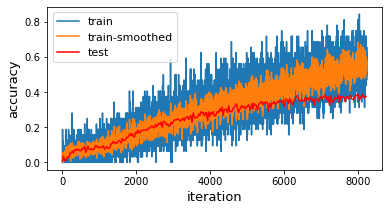

In [21]:
plt.figure(figsize = (6,3))
plt.plot(np.arange(1,len(train_accs)+1),train_accs,label='train')

train_accs_smoothing = [] 
smooth_num = 5
for i in range(len(train_accs)-smooth_num):
    begin_index = i
    end_index = i+smooth_num
    temp = train_accs[begin_index:end_index]
    train_accs_smoothing.append(np.mean(temp))
plt.plot(np.arange(smooth_num,len(train_accs)),train_accs_smoothing,label='train-smoothed')
plt.plot(np.arange(1,min(len(train_accs),(len(test_accs)-1)*30+1)+1,30),test_accs,'red',label='test')
plt.legend(fontsize=11)
plt.ylabel('accuracy',fontsize=13)
plt.xlabel('iteration',fontsize=13)
# plt.xlim(0,4000)
# plt.savefig('curves.png',dpi=200,bbox_inches='tight')